In [1]:
import argparse
import gc
import os
from datetime import datetime
import matplotlib.pyplot as plt


import numpy as np
import scipy.io as io
import torch
from torch import nn
import torch.nn.functional as F

from tqdm import tqdm

from network import *
from loss import SpectralLoss, MySpectralLoss, StructuralLoss

from tools.spectral_tools import gen_mtf, normalize_prisma, denormalize_prisma
from tools import pytorch_degradation

from dataset import open_mat
from config_dict import config
from tools.cross_correlation import local_corr_mask

import h5py



In [2]:

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # e.g., '20250612_142735'

# TODO put this in a yml file please



#class Config:
#    def __init__(self, config):
#        for key, value in config.items():
#           setattr(self, key, value)


class EarlyStopping:
    def __init__(self, patience, delta=0, relative=False):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.relative = relative 

    def check_early_stop(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
            self.no_improvement_count = 0
            return

        if not self.relative:
            improvement = loss < self.best_loss - self.delta
        else:
            improvement = (self.best_loss - loss) / self.best_loss > self.delta

        if improvement:
            self.best_loss = loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True



In [ ]:

def test_r_pnn(args):

    # Paths and env configuration
    basepath = args["input"]
    method = "R-PNN"
    out_dir = os.path.join(args["out_dir"], method, timestamp)

    gpu_number = args["gpu_number"]
    use_cpu = args["use_cpu"]

    # Training hyperparameters
    learning_rate = args["learning_rate"]

    # Satellite configuration
    sensor = config["satellite"]
    ratio = args["ratio"]

    # Environment Configuration
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

    # Devices definition
    device = torch.device(
        "cuda:0" if torch.cuda.is_available() and not use_cpu else "cpu"
    )

    if sensor == "PRISMA":
        normalize = normalize_prisma
        denormalize = denormalize_prisma
    else:
        raise "Satellite not supported"

    # Open the image

    pan, ms_lr, ms, _, wl = open_mat(basepath)

    # move to device
    ms_lr = ms_lr.to(device)
    ms = ms.to(device) if ms is not None else None
    pan = pan.to(device)

    net_scope = args["net_scope"]
    pad = nn.ReflectionPad2d(net_scope)

    # Torch configuration
    net = R_PNN_model3x3_res(scope = net_scope).to(device)

    if args["pretrained"]:
        weight_path = os.path.join("weights", "R-PNN_" + sensor + ".tar")
        if os.path.exists(weight_path):
            net.load_state_dict(torch.load(weight_path, map_location=device))
            print("Pretrained weights loaded.")
        else:
            raise FileNotFoundError(f"Pretrained weights not found at {weight_path}")
    else:
        print("Skipping weight loading — training from scratch.")


#    criterion_spec = SpectralLoss(
#        # gen_mtf(ratio, sensor, kernel_size=61, nbands=1), ratio, device
#        gen_mtf(ratio, sensor, kernel_size=args["mtf_kernel_size"], nbands=1),ratio, device).to(device) ) 

    criterion_spec = MySpectralLoss(ratio, device).to(device)

    criterion_struct = StructuralLoss(ratio).to(device)

    optim = torch.optim.Adam(net.parameters(), lr=learning_rate)

    history_loss_spec = []
    history_loss_struct = []

    # alpha = config["alpha_1"]
    alpha = args["alpha"]

    fused = []

    for band_number in range(ms_lr.shape[1]):

        # Reinitialize early stopping for each band
        early_stopping = EarlyStopping(patience=config["patience"], delta=config["delta"], relative = config["relative"])

        band_lr = ms_lr[:, band_number : band_number + 1, :, :].to(device)
        if config["interpolation"] is None:
            band = ms[:, band_number : band_number + 1, :, :].to(device) # selects band_number band but keeps the channel dimension
        else:
            band = F.interpolate(band_lr, size = (pan.shape[2], pan.shape[3]), mode = config["interpolation"]).to(device)
        # scale_factor=config["ratio"],

        # Aux data generation
        inp = torch.cat([band, pan], dim=1)
        inp = pad(inp)

        threshold = local_corr_mask(inp, ratio, sensor, device, config["semi_width"])

        ft_epochs = int(args["epochs"])

        min_loss = torch.inf
        print("Band {} / {}".format(band_number + 1, ms_lr.shape[1]))
        pbar = tqdm(range(ft_epochs))
        #pbar =  tqdm(range(1, ft_epochs + 1), desc="Epoch", position=1, leave=False)

        for epoch in pbar:

            pbar.set_description("Epoch %d/%d" % (epoch + 1, ft_epochs))

            net.train()
            optim.zero_grad()

            outputs = net(inp) # input is padded, net removes the padding 

            loss_spec,_ = criterion_spec(outputs, band_lr)
            loss_struct, loss_struct_without_threshold = criterion_struct(
                outputs,
                pan,
                threshold[:, :, net_scope:-net_scope, net_scope:-net_scope],
            )

            loss = loss_spec + alpha * loss_struct

            loss.backward()
            optim.step()

            running_loss_spec = loss_spec.item()
            running_loss_struct = loss_struct_without_threshold

            history_loss_spec.append(running_loss_spec)
            history_loss_struct.append(running_loss_struct)

            if loss.item() < min_loss:
                min_loss = loss.item()
                if not os.path.exists("temp"):
                    os.makedirs(os.path.join("temp"))
                torch.save(
                    net.state_dict(), os.path.join("temp", "R-PNN_best_model.tar")
                )

            pbar.set_postfix(
                {"Spec Loss": running_loss_spec, "Struct Loss": running_loss_struct}
            )
            if epoch+1 >= config["min_epochs"]:
                early_stopping.check_early_stop(loss.item())
                if early_stopping.stop_training:
                    break
            


            
        # DEBUGGING
        # if band_number == 0:
        #     a1 = threshold.detach().cpu().squeeze()
        #     a2 = inp.detach().cpu().squeeze()
        #     a3 = a3.detach().cpu().squeeze()
        #     a4 = outputs.detach().cpu().squeeze()
            
        #     fig, axs = plt.subplots(1,5, figsize = (10,5))
        #     axs[0].imshow(a1) 
        #     axs[0].set_title("Threshold")
        #     axs[1].imshow(a2[0,:,:])
        #     axs[1].set_title("lr_band")
        #     axs[2].imshow(a2[1,:,:])
        #     axs[2].set_title("panchromatic") 
        #     axs[3].imshow(a3)
        #     axs[3].set_title("outputs before training ")
        #     axs[4].imshow(a4)
        #     axs[4].set_title("outputs after training")

        #     fig1, axs1 = plt.subplots(1,2, figsize = (10,5))
        #     axs1[0].plot(history_loss_struct) 
        #     axs1[0].set_title("history_loss_struct")
        #     axs1[1].plot(history_loss_spec)
        #     axs1[1].set_title("history_loss_spec")
        #     plt.tight_layout()
        #     plt.show()
            

        net.load_state_dict(torch.load(os.path.join("temp", "R-PNN_best_model.tar")))

        net.eval()
        fused.append(net(inp).detach().cpu())

    fused = torch.cat(fused, 1).squeeze().numpy().transpose(1,2,0)

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    wl = wl.cpu().numpy().squeeze()

    try:
        save_path = os.path.join(
         out_dir, basepath.split(os.sep)[-1].split(".")[0] + "_R-PNN.mat"
        )
        io.savemat(save_path, {"I_MS": fused, "Wavelengths":wl})
    except Exception as e:
        save_path = os.path.join(
         out_dir, basepath.split(os.sep)[-1].split(".")[0] + "_R-PNN.h5"
        )
        with h5py.File(save_path, "w") as f:
            f.create_dataset("I_MS", data=fused)
            f.create_dataset("Wavelengths", data = wl )



    history = {"loss_spec": history_loss_spec, "loss_struct": history_loss_struct}
    io.savemat(
        os.path.join(
            out_dir, basepath.split(os.sep)[-1].split(".")[0] + "_R-PNN_stats.mat"
        ),
        history,
    )

    torch.cuda.empty_cache()
    gc.collect()

    return


test_r_pnn(config)


Skipping weight loading — training from scratch.
Band 1 / 1156


Epoch 1/2000:   0%|          | 0/2000 [00:00<?, ?it/s]/home/north-linux/anaconda3/envs/hs_pan_toolbox_env_F/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1, 1, 60, 150])) that is different to the input size (torch.Size([1, 60, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Epoch 1624/2000:  81%|████████  | 1623/2000 [00:27<00:06, 59.80it/s, Spec Loss=0.00542, Struct Loss=0.0307]
/tmp/ipykernel_422340/666191661.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weigh

Band 2 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.72it/s, Spec Loss=0.00537, Struct Loss=0.0309]


Band 3 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 60.52it/s, Spec Loss=0.0053, Struct Loss=0.0308] 


Band 4 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.13it/s, Spec Loss=0.00526, Struct Loss=0.0309]


Band 5 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.02it/s, Spec Loss=0.00528, Struct Loss=0.031]


Band 6 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.76it/s, Spec Loss=0.00523, Struct Loss=0.0313]


Band 7 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.55it/s, Spec Loss=0.00524, Struct Loss=0.0312]


Band 8 / 1156


Epoch 91/2000:   4%|▍         | 90/2000 [00:01<00:31, 60.54it/s, Spec Loss=0.00522, Struct Loss=0.0309]


Band 9 / 1156


Epoch 190/2000:   9%|▉         | 189/2000 [00:03<00:29, 60.88it/s, Spec Loss=0.00512, Struct Loss=0.0327]


Band 10 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:32, 60.38it/s, Spec Loss=0.0049, Struct Loss=0.032]  


Band 11 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.88it/s, Spec Loss=0.00487, Struct Loss=0.0319]


Band 12 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.88it/s, Spec Loss=0.00487, Struct Loss=0.0317]


Band 13 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:32, 60.38it/s, Spec Loss=0.00487, Struct Loss=0.0311]


Band 14 / 1156


Epoch 64/2000:   3%|▎         | 63/2000 [00:01<00:31, 60.71it/s, Spec Loss=0.00478, Struct Loss=0.0313]


Band 15 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.01it/s, Spec Loss=0.00467, Struct Loss=0.0314]


Band 16 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:32, 59.91it/s, Spec Loss=0.00468, Struct Loss=0.031] 


Band 17 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:32, 60.11it/s, Spec Loss=0.00462, Struct Loss=0.0307]


Band 18 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.94it/s, Spec Loss=0.00456, Struct Loss=0.0311]


Band 19 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.28it/s, Spec Loss=0.0045, Struct Loss=0.031]  


Band 20 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 60.35it/s, Spec Loss=0.0045, Struct Loss=0.0308] 


Band 21 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:32, 59.93it/s, Spec Loss=0.00445, Struct Loss=0.0304]


Band 22 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.13it/s, Spec Loss=0.00438, Struct Loss=0.0305]


Band 23 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.41it/s, Spec Loss=0.00438, Struct Loss=0.0307]


Band 24 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.40it/s, Spec Loss=0.00434, Struct Loss=0.0306]


Band 25 / 1156


Epoch 63/2000:   3%|▎         | 62/2000 [00:01<00:31, 60.73it/s, Spec Loss=0.0044, Struct Loss=0.0312] 


Band 26 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.91it/s, Spec Loss=0.00433, Struct Loss=0.0311]


Band 27 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.81it/s, Spec Loss=0.00428, Struct Loss=0.0312]


Band 28 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:31, 61.26it/s, Spec Loss=0.00429, Struct Loss=0.0309]


Band 29 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.27it/s, Spec Loss=0.00429, Struct Loss=0.031] 


Band 30 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.99it/s, Spec Loss=0.00433, Struct Loss=0.031] 


Band 31 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.41it/s, Spec Loss=0.00427, Struct Loss=0.0313]


Band 32 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.76it/s, Spec Loss=0.00429, Struct Loss=0.0315]


Band 33 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.43it/s, Spec Loss=0.00424, Struct Loss=0.0319]


Band 34 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 61.16it/s, Spec Loss=0.00424, Struct Loss=0.032] 


Band 35 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.64it/s, Spec Loss=0.00428, Struct Loss=0.032] 


Band 36 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.00it/s, Spec Loss=0.00427, Struct Loss=0.0319]


Band 37 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.72it/s, Spec Loss=0.00423, Struct Loss=0.0321]


Band 38 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.52it/s, Spec Loss=0.00416, Struct Loss=0.0326]


Band 39 / 1156


Epoch 68/2000:   3%|▎         | 67/2000 [00:01<00:32, 60.32it/s, Spec Loss=0.0042, Struct Loss=0.0327] 


Band 40 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:32, 60.20it/s, Spec Loss=0.00419, Struct Loss=0.0323]


Band 41 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.39it/s, Spec Loss=0.00414, Struct Loss=0.0322]


Band 42 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.69it/s, Spec Loss=0.00418, Struct Loss=0.032] 


Band 43 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.97it/s, Spec Loss=0.00416, Struct Loss=0.0324]


Band 44 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:31, 61.25it/s, Spec Loss=0.00415, Struct Loss=0.0321]


Band 45 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.97it/s, Spec Loss=0.00411, Struct Loss=0.0325]


Band 46 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 61.16it/s, Spec Loss=0.00415, Struct Loss=0.0322]


Band 47 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.51it/s, Spec Loss=0.00413, Struct Loss=0.0323]


Band 48 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.02it/s, Spec Loss=0.0041, Struct Loss=0.0326] 


Band 49 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.95it/s, Spec Loss=0.00412, Struct Loss=0.0325]


Band 50 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.92it/s, Spec Loss=0.00412, Struct Loss=0.0325]


Band 51 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.56it/s, Spec Loss=0.00409, Struct Loss=0.0326]


Band 52 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.44it/s, Spec Loss=0.00404, Struct Loss=0.0329]


Band 53 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:32, 60.34it/s, Spec Loss=0.00401, Struct Loss=0.0331]


Band 54 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.62it/s, Spec Loss=0.00404, Struct Loss=0.033] 


Band 55 / 1156


Epoch 64/2000:   3%|▎         | 63/2000 [00:01<00:31, 61.44it/s, Spec Loss=0.00402, Struct Loss=0.0329]


Band 56 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.65it/s, Spec Loss=0.00398, Struct Loss=0.0331]


Band 57 / 1156


Epoch 61/2000:   3%|▎         | 60/2000 [00:00<00:31, 61.18it/s, Spec Loss=0.00397, Struct Loss=0.0332]


Band 58 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.88it/s, Spec Loss=0.00394, Struct Loss=0.0332]


Band 59 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.55it/s, Spec Loss=0.0039, Struct Loss=0.0334] 


Band 60 / 1156


Epoch 65/2000:   3%|▎         | 64/2000 [00:01<00:32, 60.39it/s, Spec Loss=0.00391, Struct Loss=0.0334]


Band 61 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.91it/s, Spec Loss=0.0039, Struct Loss=0.0332] 


Band 62 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:32, 60.76it/s, Spec Loss=0.00386, Struct Loss=0.0336]


Band 63 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.19it/s, Spec Loss=0.00385, Struct Loss=0.0336]


Band 64 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:32, 59.94it/s, Spec Loss=0.00386, Struct Loss=0.0335]


Band 65 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.51it/s, Spec Loss=0.00386, Struct Loss=0.0333]


Band 66 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:31, 61.36it/s, Spec Loss=0.00388, Struct Loss=0.0332]


Band 67 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.94it/s, Spec Loss=0.00386, Struct Loss=0.0335]


Band 68 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.63it/s, Spec Loss=0.00383, Struct Loss=0.0337]


Band 69 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:32, 60.79it/s, Spec Loss=0.00385, Struct Loss=0.0335]


Band 70 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.26it/s, Spec Loss=0.00382, Struct Loss=0.0337]


Band 71 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 61.01it/s, Spec Loss=0.00386, Struct Loss=0.0339]


Band 72 / 1156


Epoch 59/2000:   3%|▎         | 58/2000 [00:00<00:32, 60.43it/s, Spec Loss=0.00387, Struct Loss=0.0334]


Band 73 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.06it/s, Spec Loss=0.00383, Struct Loss=0.0337]


Band 74 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 61.15it/s, Spec Loss=0.00382, Struct Loss=0.0337]


Band 75 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.68it/s, Spec Loss=0.00381, Struct Loss=0.0336]


Band 76 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:32, 60.12it/s, Spec Loss=0.00384, Struct Loss=0.0337]


Band 77 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:31, 60.91it/s, Spec Loss=0.00382, Struct Loss=0.0335]


Band 78 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.75it/s, Spec Loss=0.00382, Struct Loss=0.0336]


Band 79 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.80it/s, Spec Loss=0.00381, Struct Loss=0.0336]


Band 80 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.36it/s, Spec Loss=0.0038, Struct Loss=0.0335] 


Band 81 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.54it/s, Spec Loss=0.00384, Struct Loss=0.0334]


Band 82 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 61.14it/s, Spec Loss=0.0038, Struct Loss=0.0337] 


Band 83 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.41it/s, Spec Loss=0.0038, Struct Loss=0.0336] 


Band 84 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:32, 60.34it/s, Spec Loss=0.00378, Struct Loss=0.0337]


Band 85 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.24it/s, Spec Loss=0.00379, Struct Loss=0.0336]


Band 86 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.14it/s, Spec Loss=0.00379, Struct Loss=0.0337]


Band 87 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.14it/s, Spec Loss=0.00377, Struct Loss=0.0337]


Band 88 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.34it/s, Spec Loss=0.00377, Struct Loss=0.0339]


Band 89 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:33, 58.88it/s, Spec Loss=0.00376, Struct Loss=0.0337]


Band 90 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.97it/s, Spec Loss=0.00372, Struct Loss=0.0338]


Band 91 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:32, 60.38it/s, Spec Loss=0.00373, Struct Loss=0.0336]


Band 92 / 1156


Epoch 61/2000:   3%|▎         | 60/2000 [00:01<00:32, 59.10it/s, Spec Loss=0.00371, Struct Loss=0.0339]


Band 93 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.65it/s, Spec Loss=0.00367, Struct Loss=0.0342]


Band 94 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.38it/s, Spec Loss=0.00369, Struct Loss=0.0338]


Band 95 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.45it/s, Spec Loss=0.00367, Struct Loss=0.0341]


Band 96 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.33it/s, Spec Loss=0.00368, Struct Loss=0.034] 


Band 97 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:32, 59.07it/s, Spec Loss=0.00367, Struct Loss=0.0339]


Band 98 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.55it/s, Spec Loss=0.00368, Struct Loss=0.0339]


Band 99 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.65it/s, Spec Loss=0.00365, Struct Loss=0.0341]


Band 100 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.11it/s, Spec Loss=0.00367, Struct Loss=0.0339]


Band 101 / 1156


Epoch 63/2000:   3%|▎         | 62/2000 [00:01<00:32, 60.40it/s, Spec Loss=0.00368, Struct Loss=0.0338]


Band 102 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:32, 59.85it/s, Spec Loss=0.00365, Struct Loss=0.0338]


Band 103 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.83it/s, Spec Loss=0.00365, Struct Loss=0.034] 


Band 104 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:32, 60.03it/s, Spec Loss=0.00371, Struct Loss=0.0336]


Band 105 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:32, 60.30it/s, Spec Loss=0.00369, Struct Loss=0.0337]


Band 106 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.26it/s, Spec Loss=0.00367, Struct Loss=0.0338]


Band 107 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:31, 60.90it/s, Spec Loss=0.00365, Struct Loss=0.0336]


Band 108 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:31, 61.10it/s, Spec Loss=0.00368, Struct Loss=0.0338]


Band 109 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.49it/s, Spec Loss=0.00367, Struct Loss=0.0337]


Band 110 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.19it/s, Spec Loss=0.00367, Struct Loss=0.0337]


Band 111 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.22it/s, Spec Loss=0.00366, Struct Loss=0.0338]


Band 112 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:32, 60.19it/s, Spec Loss=0.00367, Struct Loss=0.0337]


Band 113 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.59it/s, Spec Loss=0.00366, Struct Loss=0.0336]


Band 114 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.54it/s, Spec Loss=0.00365, Struct Loss=0.0337]


Band 115 / 1156


Epoch 58/2000:   3%|▎         | 57/2000 [00:00<00:32, 60.11it/s, Spec Loss=0.00364, Struct Loss=0.0336]


Band 116 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.49it/s, Spec Loss=0.00363, Struct Loss=0.0338]


Band 117 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 61.01it/s, Spec Loss=0.00364, Struct Loss=0.0337]


Band 118 / 1156


Epoch 58/2000:   3%|▎         | 57/2000 [00:00<00:32, 60.65it/s, Spec Loss=0.00366, Struct Loss=0.0335]


Band 119 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.64it/s, Spec Loss=0.00365, Struct Loss=0.0337]


Band 120 / 1156


Epoch 60/2000:   3%|▎         | 59/2000 [00:00<00:32, 59.55it/s, Spec Loss=0.00361, Struct Loss=0.0336]


Band 121 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.69it/s, Spec Loss=0.00361, Struct Loss=0.0337]


Band 122 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.78it/s, Spec Loss=0.00363, Struct Loss=0.0338]


Band 123 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.02it/s, Spec Loss=0.0036, Struct Loss=0.0339] 


Band 124 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.71it/s, Spec Loss=0.00363, Struct Loss=0.0336]


Band 125 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.19it/s, Spec Loss=0.00363, Struct Loss=0.0337]


Band 126 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.86it/s, Spec Loss=0.00362, Struct Loss=0.0337]


Band 127 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.43it/s, Spec Loss=0.00361, Struct Loss=0.0337]


Band 128 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.78it/s, Spec Loss=0.00359, Struct Loss=0.0336]


Band 129 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.22it/s, Spec Loss=0.00359, Struct Loss=0.0337]


Band 130 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.98it/s, Spec Loss=0.00357, Struct Loss=0.0339]


Band 131 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.04it/s, Spec Loss=0.00363, Struct Loss=0.0338]


Band 132 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.68it/s, Spec Loss=0.00358, Struct Loss=0.0339]


Band 133 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.39it/s, Spec Loss=0.00358, Struct Loss=0.0337]


Band 134 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.44it/s, Spec Loss=0.00357, Struct Loss=0.0339]


Band 135 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:32, 59.28it/s, Spec Loss=0.0036, Struct Loss=0.0339] 


Band 136 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 59.23it/s, Spec Loss=0.00357, Struct Loss=0.0339]


Band 137 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 59.00it/s, Spec Loss=0.00355, Struct Loss=0.0338]


Band 138 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.27it/s, Spec Loss=0.00356, Struct Loss=0.0338]


Band 139 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.50it/s, Spec Loss=0.00356, Struct Loss=0.0339]


Band 140 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.47it/s, Spec Loss=0.00355, Struct Loss=0.0341]


Band 141 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.13it/s, Spec Loss=0.00355, Struct Loss=0.0341]


Band 142 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.90it/s, Spec Loss=0.00357, Struct Loss=0.034] 


Band 143 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.81it/s, Spec Loss=0.00355, Struct Loss=0.0341]


Band 144 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.34it/s, Spec Loss=0.00353, Struct Loss=0.0342]


Band 145 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.42it/s, Spec Loss=0.00355, Struct Loss=0.034] 


Band 146 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:32, 59.48it/s, Spec Loss=0.00358, Struct Loss=0.0339]


Band 147 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.41it/s, Spec Loss=0.00358, Struct Loss=0.0341]


Band 148 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:32, 59.34it/s, Spec Loss=0.00356, Struct Loss=0.034] 


Band 149 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.52it/s, Spec Loss=0.00356, Struct Loss=0.0341]


Band 150 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.59it/s, Spec Loss=0.00353, Struct Loss=0.034] 


Band 151 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.22it/s, Spec Loss=0.00351, Struct Loss=0.0341]


Band 152 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.06it/s, Spec Loss=0.00351, Struct Loss=0.0342]


Band 153 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.22it/s, Spec Loss=0.00352, Struct Loss=0.0342]


Band 154 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.77it/s, Spec Loss=0.00353, Struct Loss=0.034] 


Band 155 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.62it/s, Spec Loss=0.00351, Struct Loss=0.0342]


Band 156 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.52it/s, Spec Loss=0.00352, Struct Loss=0.0342]


Band 157 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.18it/s, Spec Loss=0.00352, Struct Loss=0.0341]


Band 158 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.50it/s, Spec Loss=0.00348, Struct Loss=0.0342]


Band 159 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.91it/s, Spec Loss=0.00349, Struct Loss=0.0342]


Band 160 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:32, 60.15it/s, Spec Loss=0.00349, Struct Loss=0.0342]


Band 161 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.45it/s, Spec Loss=0.00349, Struct Loss=0.0344]


Band 162 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.78it/s, Spec Loss=0.0035, Struct Loss=0.0343] 


Band 163 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 60.32it/s, Spec Loss=0.00349, Struct Loss=0.0342]


Band 164 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.01it/s, Spec Loss=0.00348, Struct Loss=0.0343]


Band 165 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.68it/s, Spec Loss=0.00349, Struct Loss=0.0342]


Band 166 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 61.08it/s, Spec Loss=0.00351, Struct Loss=0.0341]


Band 167 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.65it/s, Spec Loss=0.00348, Struct Loss=0.0342]


Band 168 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.49it/s, Spec Loss=0.00348, Struct Loss=0.0344]


Band 169 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.17it/s, Spec Loss=0.00348, Struct Loss=0.0345]


Band 170 / 1156


Epoch 58/2000:   3%|▎         | 57/2000 [00:00<00:31, 61.29it/s, Spec Loss=0.00347, Struct Loss=0.0343]


Band 171 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.11it/s, Spec Loss=0.00346, Struct Loss=0.0344]


Band 172 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.16it/s, Spec Loss=0.00351, Struct Loss=0.0342]


Band 173 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.94it/s, Spec Loss=0.00348, Struct Loss=0.0344]


Band 174 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.56it/s, Spec Loss=0.00348, Struct Loss=0.0345]


Band 175 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.05it/s, Spec Loss=0.00348, Struct Loss=0.0344]


Band 176 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:31, 61.47it/s, Spec Loss=0.00349, Struct Loss=0.0342]


Band 177 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:31, 61.94it/s, Spec Loss=0.00347, Struct Loss=0.0343]


Band 178 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.15it/s, Spec Loss=0.00346, Struct Loss=0.0345]


Band 179 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.38it/s, Spec Loss=0.00347, Struct Loss=0.0344]


Band 180 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.80it/s, Spec Loss=0.00345, Struct Loss=0.0344]


Band 181 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.60it/s, Spec Loss=0.00345, Struct Loss=0.0343]


Band 182 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.30it/s, Spec Loss=0.00343, Struct Loss=0.0343]


Band 183 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.34it/s, Spec Loss=0.00343, Struct Loss=0.0343]


Band 184 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.22it/s, Spec Loss=0.00346, Struct Loss=0.0344]


Band 185 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.21it/s, Spec Loss=0.00344, Struct Loss=0.0344]


Band 186 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.41it/s, Spec Loss=0.00344, Struct Loss=0.0344]


Band 187 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.58it/s, Spec Loss=0.00344, Struct Loss=0.0343]


Band 188 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.68it/s, Spec Loss=0.0034, Struct Loss=0.0347] 


Band 189 / 1156


Epoch 71/2000:   4%|▎         | 70/2000 [00:01<00:31, 61.05it/s, Spec Loss=0.00345, Struct Loss=0.0345]


Band 190 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:32, 60.68it/s, Spec Loss=0.0034, Struct Loss=0.0345] 


Band 191 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.52it/s, Spec Loss=0.0034, Struct Loss=0.0345] 


Band 192 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 60.33it/s, Spec Loss=0.00344, Struct Loss=0.0349]


Band 193 / 1156


Epoch 64/2000:   3%|▎         | 63/2000 [00:01<00:31, 60.94it/s, Spec Loss=0.00341, Struct Loss=0.0345]


Band 194 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.91it/s, Spec Loss=0.00342, Struct Loss=0.0343]


Band 195 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.44it/s, Spec Loss=0.0034, Struct Loss=0.0345] 


Band 196 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.41it/s, Spec Loss=0.00341, Struct Loss=0.0345]


Band 197 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.90it/s, Spec Loss=0.00343, Struct Loss=0.0344]


Band 198 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.33it/s, Spec Loss=0.00341, Struct Loss=0.0344]


Band 199 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.95it/s, Spec Loss=0.0034, Struct Loss=0.0346] 


Band 200 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.33it/s, Spec Loss=0.00339, Struct Loss=0.0346]


Band 201 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.92it/s, Spec Loss=0.00339, Struct Loss=0.0345]


Band 202 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.75it/s, Spec Loss=0.00337, Struct Loss=0.0347]


Band 203 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 60.72it/s, Spec Loss=0.00339, Struct Loss=0.0344]


Band 204 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.22it/s, Spec Loss=0.00339, Struct Loss=0.0345]


Band 205 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 60.63it/s, Spec Loss=0.00339, Struct Loss=0.0346]


Band 206 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.36it/s, Spec Loss=0.00338, Struct Loss=0.0346]


Band 207 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.58it/s, Spec Loss=0.00338, Struct Loss=0.0346]


Band 208 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.83it/s, Spec Loss=0.0034, Struct Loss=0.0345] 


Band 209 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.17it/s, Spec Loss=0.00343, Struct Loss=0.0345]


Band 210 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.10it/s, Spec Loss=0.0034, Struct Loss=0.0346] 


Band 211 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.37it/s, Spec Loss=0.00339, Struct Loss=0.0345]


Band 212 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.55it/s, Spec Loss=0.00344, Struct Loss=0.0344]


Band 213 / 1156


Epoch 60/2000:   3%|▎         | 59/2000 [00:00<00:31, 61.11it/s, Spec Loss=0.00344, Struct Loss=0.0343]


Band 214 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.89it/s, Spec Loss=0.00341, Struct Loss=0.0344]


Band 215 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.64it/s, Spec Loss=0.00341, Struct Loss=0.0345]


Band 216 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.86it/s, Spec Loss=0.0034, Struct Loss=0.0345] 


Band 217 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.41it/s, Spec Loss=0.0034, Struct Loss=0.0345] 


Band 218 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.87it/s, Spec Loss=0.00339, Struct Loss=0.0346]


Band 219 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.47it/s, Spec Loss=0.0034, Struct Loss=0.0344] 


Band 220 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.22it/s, Spec Loss=0.0034, Struct Loss=0.0346] 


Band 221 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.80it/s, Spec Loss=0.00338, Struct Loss=0.0346]


Band 222 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.76it/s, Spec Loss=0.00339, Struct Loss=0.0345]


Band 223 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.17it/s, Spec Loss=0.00338, Struct Loss=0.0347]


Band 224 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.60it/s, Spec Loss=0.00339, Struct Loss=0.0346]


Band 225 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.32it/s, Spec Loss=0.00339, Struct Loss=0.0346]


Band 226 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:32, 59.84it/s, Spec Loss=0.00337, Struct Loss=0.0347]


Band 227 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.80it/s, Spec Loss=0.00336, Struct Loss=0.0346]


Band 228 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.65it/s, Spec Loss=0.00337, Struct Loss=0.0346]


Band 229 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.37it/s, Spec Loss=0.00339, Struct Loss=0.0345]


Band 230 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.02it/s, Spec Loss=0.00339, Struct Loss=0.0346]


Band 231 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:33, 58.66it/s, Spec Loss=0.00339, Struct Loss=0.0343]


Band 232 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 59.13it/s, Spec Loss=0.00336, Struct Loss=0.0347]


Band 233 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:32, 60.48it/s, Spec Loss=0.00336, Struct Loss=0.0346]


Band 234 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.01it/s, Spec Loss=0.00336, Struct Loss=0.0346]


Band 235 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.20it/s, Spec Loss=0.00336, Struct Loss=0.0347]


Band 236 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.21it/s, Spec Loss=0.00337, Struct Loss=0.0347]


Band 237 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.24it/s, Spec Loss=0.00339, Struct Loss=0.0346]


Band 238 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.43it/s, Spec Loss=0.00336, Struct Loss=0.0347]


Band 239 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:32, 59.50it/s, Spec Loss=0.00337, Struct Loss=0.0348]


Band 240 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.99it/s, Spec Loss=0.00334, Struct Loss=0.0346]


Band 241 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.66it/s, Spec Loss=0.00334, Struct Loss=0.0348]


Band 242 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.51it/s, Spec Loss=0.00334, Struct Loss=0.0349]


Band 243 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.49it/s, Spec Loss=0.00336, Struct Loss=0.0348]


Band 244 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.12it/s, Spec Loss=0.00335, Struct Loss=0.0348]


Band 245 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.31it/s, Spec Loss=0.00335, Struct Loss=0.0347]


Band 246 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.71it/s, Spec Loss=0.00334, Struct Loss=0.0349]


Band 247 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.13it/s, Spec Loss=0.00334, Struct Loss=0.0349]


Band 248 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.89it/s, Spec Loss=0.00336, Struct Loss=0.0347]


Band 249 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.42it/s, Spec Loss=0.00331, Struct Loss=0.035] 


Band 250 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.93it/s, Spec Loss=0.00332, Struct Loss=0.035] 


Band 251 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.83it/s, Spec Loss=0.00334, Struct Loss=0.035] 


Band 252 / 1156


Epoch 62/2000:   3%|▎         | 61/2000 [00:01<00:32, 59.53it/s, Spec Loss=0.0033, Struct Loss=0.0352] 


Band 253 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.91it/s, Spec Loss=0.0033, Struct Loss=0.035]  


Band 254 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 59.20it/s, Spec Loss=0.00331, Struct Loss=0.0349]


Band 255 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.93it/s, Spec Loss=0.0033, Struct Loss=0.0351] 


Band 256 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.57it/s, Spec Loss=0.00331, Struct Loss=0.035] 


Band 257 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.52it/s, Spec Loss=0.00331, Struct Loss=0.0352]


Band 258 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.63it/s, Spec Loss=0.0033, Struct Loss=0.0352] 


Band 259 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.21it/s, Spec Loss=0.0033, Struct Loss=0.0351]


Band 260 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.80it/s, Spec Loss=0.0033, Struct Loss=0.0351] 


Band 261 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.67it/s, Spec Loss=0.00327, Struct Loss=0.0351]


Band 262 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:32, 60.55it/s, Spec Loss=0.00328, Struct Loss=0.0353]


Band 263 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.61it/s, Spec Loss=0.0033, Struct Loss=0.0353] 


Band 264 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.02it/s, Spec Loss=0.00329, Struct Loss=0.0353]


Band 265 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.48it/s, Spec Loss=0.00327, Struct Loss=0.0352]


Band 266 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.32it/s, Spec Loss=0.00328, Struct Loss=0.0352]


Band 267 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.18it/s, Spec Loss=0.00326, Struct Loss=0.0354]


Band 268 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.39it/s, Spec Loss=0.00326, Struct Loss=0.0353]


Band 269 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.44it/s, Spec Loss=0.00324, Struct Loss=0.0356]


Band 270 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.38it/s, Spec Loss=0.00325, Struct Loss=0.0355]


Band 271 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.21it/s, Spec Loss=0.00325, Struct Loss=0.0354]


Band 272 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.32it/s, Spec Loss=0.00325, Struct Loss=0.0356]


Band 273 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:33, 59.00it/s, Spec Loss=0.00325, Struct Loss=0.0357]


Band 274 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 59.04it/s, Spec Loss=0.00324, Struct Loss=0.0357]


Band 275 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.83it/s, Spec Loss=0.00323, Struct Loss=0.0357]


Band 276 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.79it/s, Spec Loss=0.00322, Struct Loss=0.0358]


Band 277 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.62it/s, Spec Loss=0.00322, Struct Loss=0.0358]


Band 278 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.43it/s, Spec Loss=0.00329, Struct Loss=0.0357]


Band 279 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:33, 58.57it/s, Spec Loss=0.00323, Struct Loss=0.0358]


Band 280 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.28it/s, Spec Loss=0.00321, Struct Loss=0.0358]


Band 281 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 59.27it/s, Spec Loss=0.00321, Struct Loss=0.0359]


Band 282 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.43it/s, Spec Loss=0.00321, Struct Loss=0.036] 


Band 283 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.63it/s, Spec Loss=0.00322, Struct Loss=0.0358]


Band 284 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.35it/s, Spec Loss=0.00324, Struct Loss=0.0357]


Band 285 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 59.14it/s, Spec Loss=0.00321, Struct Loss=0.0359]


Band 286 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.31it/s, Spec Loss=0.00322, Struct Loss=0.0358]


Band 287 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.07it/s, Spec Loss=0.00321, Struct Loss=0.0358]


Band 288 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.77it/s, Spec Loss=0.0032, Struct Loss=0.0359] 


Band 289 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.05it/s, Spec Loss=0.0032, Struct Loss=0.036]  


Band 290 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.01it/s, Spec Loss=0.00321, Struct Loss=0.036] 


Band 291 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 59.20it/s, Spec Loss=0.0032, Struct Loss=0.036]  


Band 292 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:33, 58.81it/s, Spec Loss=0.0032, Struct Loss=0.0359] 


Band 293 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:32, 59.25it/s, Spec Loss=0.00321, Struct Loss=0.0359]


Band 294 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.78it/s, Spec Loss=0.00322, Struct Loss=0.0359]


Band 295 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 59.40it/s, Spec Loss=0.00321, Struct Loss=0.0358]


Band 296 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 59.42it/s, Spec Loss=0.00319, Struct Loss=0.0361]


Band 297 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:32, 59.43it/s, Spec Loss=0.00317, Struct Loss=0.0362]


Band 298 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:33, 58.54it/s, Spec Loss=0.0032, Struct Loss=0.036]  


Band 299 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.67it/s, Spec Loss=0.00318, Struct Loss=0.0361]


Band 300 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 59.06it/s, Spec Loss=0.00316, Struct Loss=0.036] 


Band 301 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:33, 58.90it/s, Spec Loss=0.00317, Struct Loss=0.0362]


Band 302 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.96it/s, Spec Loss=0.00317, Struct Loss=0.0361]


Band 303 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:33, 58.86it/s, Spec Loss=0.00316, Struct Loss=0.0361]


Band 304 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.86it/s, Spec Loss=0.00315, Struct Loss=0.0361]


Band 305 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:32, 59.17it/s, Spec Loss=0.00314, Struct Loss=0.0361]


Band 306 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.12it/s, Spec Loss=0.00316, Struct Loss=0.0363]


Band 307 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.00it/s, Spec Loss=0.00313, Struct Loss=0.0362]


Band 308 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.41it/s, Spec Loss=0.00312, Struct Loss=0.0362]


Band 309 / 1156


Epoch 78/2000:   4%|▍         | 77/2000 [00:01<00:32, 59.16it/s, Spec Loss=0.00315, Struct Loss=0.0362]


Band 310 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.83it/s, Spec Loss=0.00314, Struct Loss=0.0363]


Band 311 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.98it/s, Spec Loss=0.00311, Struct Loss=0.0363]


Band 312 / 1156


Epoch 69/2000:   3%|▎         | 68/2000 [00:01<00:32, 58.68it/s, Spec Loss=0.0031, Struct Loss=0.0363] 


Band 313 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.64it/s, Spec Loss=0.00312, Struct Loss=0.0362]


Band 314 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.39it/s, Spec Loss=0.00318, Struct Loss=0.036] 


Band 315 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.43it/s, Spec Loss=0.00311, Struct Loss=0.0362]


Band 316 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.69it/s, Spec Loss=0.00312, Struct Loss=0.0361]


Band 317 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.00it/s, Spec Loss=0.00309, Struct Loss=0.0362]


Band 318 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.48it/s, Spec Loss=0.00309, Struct Loss=0.0361]


Band 319 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 59.18it/s, Spec Loss=0.0031, Struct Loss=0.036]  


Band 320 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.52it/s, Spec Loss=0.00314, Struct Loss=0.036] 


Band 321 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.53it/s, Spec Loss=0.00311, Struct Loss=0.036] 


Band 322 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:33, 58.65it/s, Spec Loss=0.0031, Struct Loss=0.0359] 


Band 323 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.42it/s, Spec Loss=0.00311, Struct Loss=0.0359]


Band 324 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.11it/s, Spec Loss=0.00311, Struct Loss=0.0358]


Band 325 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:33, 58.71it/s, Spec Loss=0.0031, Struct Loss=0.0359] 


Band 326 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.59it/s, Spec Loss=0.00311, Struct Loss=0.0356]


Band 327 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.20it/s, Spec Loss=0.00312, Struct Loss=0.0356]


Band 328 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.01it/s, Spec Loss=0.0031, Struct Loss=0.0356] 


Band 329 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.40it/s, Spec Loss=0.0031, Struct Loss=0.0355] 


Band 330 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 59.11it/s, Spec Loss=0.00311, Struct Loss=0.0354]


Band 331 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.06it/s, Spec Loss=0.00311, Struct Loss=0.0352]


Band 332 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.77it/s, Spec Loss=0.00314, Struct Loss=0.035] 


Band 333 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.22it/s, Spec Loss=0.00312, Struct Loss=0.0351]


Band 334 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:33, 58.64it/s, Spec Loss=0.00313, Struct Loss=0.0348]


Band 335 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 57.82it/s, Spec Loss=0.00315, Struct Loss=0.0347]


Band 336 / 1156


Epoch 69/2000:   3%|▎         | 68/2000 [00:01<00:32, 59.09it/s, Spec Loss=0.00315, Struct Loss=0.0346]


Band 337 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.31it/s, Spec Loss=0.00316, Struct Loss=0.0345]


Band 338 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.17it/s, Spec Loss=0.00317, Struct Loss=0.0343]


Band 339 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.65it/s, Spec Loss=0.00314, Struct Loss=0.0344]


Band 340 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:33, 58.42it/s, Spec Loss=0.00315, Struct Loss=0.0341]


Band 341 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.62it/s, Spec Loss=0.00314, Struct Loss=0.0341]


Band 342 / 1156


Epoch 61/2000:   3%|▎         | 60/2000 [00:01<00:33, 57.61it/s, Spec Loss=0.00316, Struct Loss=0.0341]


Band 343 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.77it/s, Spec Loss=0.00314, Struct Loss=0.0341]


Band 344 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.53it/s, Spec Loss=0.00314, Struct Loss=0.034] 


Band 345 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.57it/s, Spec Loss=0.00312, Struct Loss=0.0342]


Band 346 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:33, 58.39it/s, Spec Loss=0.00311, Struct Loss=0.034] 


Band 347 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.87it/s, Spec Loss=0.0031, Struct Loss=0.034]  


Band 348 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.99it/s, Spec Loss=0.00311, Struct Loss=0.0338]


Band 349 / 1156


Epoch 77/2000:   4%|▍         | 76/2000 [00:01<00:32, 58.92it/s, Spec Loss=0.0031, Struct Loss=0.0336] 


Band 350 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.13it/s, Spec Loss=0.00309, Struct Loss=0.0336]


Band 351 / 1156


Epoch 80/2000:   4%|▍         | 79/2000 [00:01<00:32, 59.28it/s, Spec Loss=0.00308, Struct Loss=0.0336]


Band 352 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.94it/s, Spec Loss=0.00308, Struct Loss=0.0336]


Band 353 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.96it/s, Spec Loss=0.00307, Struct Loss=0.0336]


Band 354 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.76it/s, Spec Loss=0.00307, Struct Loss=0.0338]


Band 355 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.56it/s, Spec Loss=0.00307, Struct Loss=0.0337]


Band 356 / 1156


Epoch 74/2000:   4%|▎         | 73/2000 [00:01<00:32, 59.10it/s, Spec Loss=0.00305, Struct Loss=0.0336]


Band 357 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:34, 57.32it/s, Spec Loss=0.00306, Struct Loss=0.0337]


Band 358 / 1156


Epoch 69/2000:   3%|▎         | 68/2000 [00:01<00:32, 58.98it/s, Spec Loss=0.00307, Struct Loss=0.0335]


Band 359 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.30it/s, Spec Loss=0.00314, Struct Loss=0.0335]


Band 360 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.47it/s, Spec Loss=0.00307, Struct Loss=0.0335]


Band 361 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 59.17it/s, Spec Loss=0.00308, Struct Loss=0.0335]


Band 362 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:33, 58.72it/s, Spec Loss=0.00306, Struct Loss=0.0336]


Band 363 / 1156


Epoch 63/2000:   3%|▎         | 62/2000 [00:01<00:33, 58.59it/s, Spec Loss=0.00306, Struct Loss=0.0337]


Band 364 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.17it/s, Spec Loss=0.00307, Struct Loss=0.0338]


Band 365 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.32it/s, Spec Loss=0.00306, Struct Loss=0.0339]


Band 366 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.04it/s, Spec Loss=0.00306, Struct Loss=0.0339]


Band 367 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.01it/s, Spec Loss=0.00303, Struct Loss=0.034]


Band 368 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.45it/s, Spec Loss=0.00302, Struct Loss=0.0342]


Band 369 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.61it/s, Spec Loss=0.00312, Struct Loss=0.034] 


Band 370 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.35it/s, Spec Loss=0.00301, Struct Loss=0.0343]


Band 371 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 57.87it/s, Spec Loss=0.003, Struct Loss=0.0345]  


Band 372 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.56it/s, Spec Loss=0.00301, Struct Loss=0.0346]


Band 373 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.14it/s, Spec Loss=0.00303, Struct Loss=0.0347]


Band 374 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.07it/s, Spec Loss=0.003, Struct Loss=0.0349]  


Band 375 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.44it/s, Spec Loss=0.003, Struct Loss=0.0351]  


Band 376 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.25it/s, Spec Loss=0.00297, Struct Loss=0.0353]


Band 377 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.24it/s, Spec Loss=0.00296, Struct Loss=0.0356]


Band 378 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.21it/s, Spec Loss=0.00302, Struct Loss=0.0355]


Band 379 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.14it/s, Spec Loss=0.00316, Struct Loss=0.0355]


Band 380 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.17it/s, Spec Loss=0.00299, Struct Loss=0.0357]


Band 381 / 1156


Epoch 75/2000:   4%|▎         | 74/2000 [00:01<00:32, 58.63it/s, Spec Loss=0.00294, Struct Loss=0.0361]


Band 382 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.13it/s, Spec Loss=0.00294, Struct Loss=0.0361]


Band 383 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:33, 59.00it/s, Spec Loss=0.00294, Struct Loss=0.0362]


Band 384 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.99it/s, Spec Loss=0.00295, Struct Loss=0.0364]


Band 385 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.45it/s, Spec Loss=0.00293, Struct Loss=0.0364]


Band 386 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:34, 57.15it/s, Spec Loss=0.00293, Struct Loss=0.0365]


Band 387 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 57.62it/s, Spec Loss=0.00294, Struct Loss=0.0367]


Band 388 / 1156


Epoch 76/2000:   4%|▍         | 75/2000 [00:01<00:33, 58.23it/s, Spec Loss=0.00292, Struct Loss=0.0368]


Band 389 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 57.61it/s, Spec Loss=0.00293, Struct Loss=0.0367]


Band 390 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:33, 58.30it/s, Spec Loss=0.00291, Struct Loss=0.0369]


Band 391 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.31it/s, Spec Loss=0.00291, Struct Loss=0.037] 


Band 392 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.58it/s, Spec Loss=0.00292, Struct Loss=0.037] 


Band 393 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:32, 60.55it/s, Spec Loss=0.00292, Struct Loss=0.037] 


Band 394 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.05it/s, Spec Loss=0.00291, Struct Loss=0.0372]


Band 395 / 1156


Epoch 73/2000:   4%|▎         | 72/2000 [00:01<00:32, 58.82it/s, Spec Loss=0.00293, Struct Loss=0.037] 


Band 396 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:32, 59.71it/s, Spec Loss=0.00292, Struct Loss=0.0372]


Band 397 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.63it/s, Spec Loss=0.00292, Struct Loss=0.0372]


Band 398 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 59.02it/s, Spec Loss=0.00292, Struct Loss=0.0373]


Band 399 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:32, 60.24it/s, Spec Loss=0.00292, Struct Loss=0.0373]


Band 400 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 60.59it/s, Spec Loss=0.00291, Struct Loss=0.0374]


Band 401 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:32, 59.17it/s, Spec Loss=0.00291, Struct Loss=0.0374]


Band 402 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 60.48it/s, Spec Loss=0.0029, Struct Loss=0.0374] 


Band 403 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 59.15it/s, Spec Loss=0.0029, Struct Loss=0.0374] 


Band 404 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 59.14it/s, Spec Loss=0.00289, Struct Loss=0.0375]


Band 405 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:32, 59.36it/s, Spec Loss=0.00293, Struct Loss=0.0373]


Band 406 / 1156


Epoch 69/2000:   3%|▎         | 68/2000 [00:01<00:32, 59.92it/s, Spec Loss=0.00293, Struct Loss=0.0373]


Band 407 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.42it/s, Spec Loss=0.0029, Struct Loss=0.0375] 


Band 408 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 59.05it/s, Spec Loss=0.00288, Struct Loss=0.0376]


Band 409 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.70it/s, Spec Loss=0.00288, Struct Loss=0.0377]


Band 410 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.56it/s, Spec Loss=0.00287, Struct Loss=0.0378]


Band 411 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.37it/s, Spec Loss=0.00288, Struct Loss=0.0376]


Band 412 / 1156


Epoch 63/2000:   3%|▎         | 62/2000 [00:01<00:32, 59.60it/s, Spec Loss=0.00287, Struct Loss=0.0377]


Band 413 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.52it/s, Spec Loss=0.00287, Struct Loss=0.0377]


Band 414 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.87it/s, Spec Loss=0.00288, Struct Loss=0.0377]


Band 415 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.14it/s, Spec Loss=0.00287, Struct Loss=0.0377]


Band 416 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 60.03it/s, Spec Loss=0.00289, Struct Loss=0.0377]


Band 417 / 1156


Epoch 91/2000:   4%|▍         | 90/2000 [00:01<00:32, 59.38it/s, Spec Loss=0.00287, Struct Loss=0.0378]


Band 418 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 60.55it/s, Spec Loss=0.00286, Struct Loss=0.038] 


Band 419 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.57it/s, Spec Loss=0.00286, Struct Loss=0.038] 


Band 420 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 59.21it/s, Spec Loss=0.00285, Struct Loss=0.038] 


Band 421 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.88it/s, Spec Loss=0.00286, Struct Loss=0.0379]


Band 422 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.44it/s, Spec Loss=0.00286, Struct Loss=0.038] 


Band 423 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.78it/s, Spec Loss=0.00287, Struct Loss=0.0379]


Band 424 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.53it/s, Spec Loss=0.00285, Struct Loss=0.0379]


Band 425 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.42it/s, Spec Loss=0.00284, Struct Loss=0.038] 


Band 426 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 60.00it/s, Spec Loss=0.00285, Struct Loss=0.038] 


Band 427 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.80it/s, Spec Loss=0.00285, Struct Loss=0.038] 


Band 428 / 1156


Epoch 59/2000:   3%|▎         | 58/2000 [00:00<00:33, 58.32it/s, Spec Loss=0.00285, Struct Loss=0.038] 


Band 429 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.27it/s, Spec Loss=0.00283, Struct Loss=0.0381]


Band 430 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.02it/s, Spec Loss=0.00279, Struct Loss=0.0383]


Band 431 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.91it/s, Spec Loss=0.00282, Struct Loss=0.0382]


Band 432 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.44it/s, Spec Loss=0.00282, Struct Loss=0.0382]


Band 433 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.00it/s, Spec Loss=0.00282, Struct Loss=0.0381]


Band 434 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.47it/s, Spec Loss=0.00283, Struct Loss=0.0381]


Band 435 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.53it/s, Spec Loss=0.0028, Struct Loss=0.0382] 


Band 436 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.77it/s, Spec Loss=0.0028, Struct Loss=0.0383] 


Band 437 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.68it/s, Spec Loss=0.00281, Struct Loss=0.0383]


Band 438 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.68it/s, Spec Loss=0.00281, Struct Loss=0.0382]


Band 439 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.54it/s, Spec Loss=0.0028, Struct Loss=0.0383] 


Band 440 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 59.08it/s, Spec Loss=0.00281, Struct Loss=0.0383]


Band 441 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.04it/s, Spec Loss=0.0028, Struct Loss=0.0383] 


Band 442 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.55it/s, Spec Loss=0.0028, Struct Loss=0.0383] 


Band 443 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.41it/s, Spec Loss=0.0028, Struct Loss=0.0383] 


Band 444 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 59.56it/s, Spec Loss=0.00281, Struct Loss=0.0382]


Band 445 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 59.37it/s, Spec Loss=0.00281, Struct Loss=0.0383]


Band 446 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.66it/s, Spec Loss=0.00287, Struct Loss=0.0382]


Band 447 / 1156


Epoch 67/2000:   3%|▎         | 66/2000 [00:01<00:32, 60.08it/s, Spec Loss=0.00285, Struct Loss=0.038] 


Band 448 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.18it/s, Spec Loss=0.00285, Struct Loss=0.0381]


Band 449 / 1156


Epoch 93/2000:   5%|▍         | 92/2000 [00:01<00:32, 59.30it/s, Spec Loss=0.00283, Struct Loss=0.0382]


Band 450 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.94it/s, Spec Loss=0.00281, Struct Loss=0.0383]


Band 451 / 1156


Epoch 58/2000:   3%|▎         | 57/2000 [00:00<00:32, 58.90it/s, Spec Loss=0.0028, Struct Loss=0.0383] 


Band 452 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.04it/s, Spec Loss=0.0028, Struct Loss=0.0384] 


Band 453 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.43it/s, Spec Loss=0.00279, Struct Loss=0.0384]


Band 454 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 57.79it/s, Spec Loss=0.00281, Struct Loss=0.0384]


Band 455 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.30it/s, Spec Loss=0.0028, Struct Loss=0.0384] 


Band 456 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.63it/s, Spec Loss=0.00279, Struct Loss=0.0384]


Band 457 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 59.20it/s, Spec Loss=0.00279, Struct Loss=0.0383]


Band 458 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.62it/s, Spec Loss=0.0028, Struct Loss=0.0383] 


Band 459 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.43it/s, Spec Loss=0.00282, Struct Loss=0.0383]


Band 460 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.86it/s, Spec Loss=0.00281, Struct Loss=0.0383]


Band 461 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 59.00it/s, Spec Loss=0.0028, Struct Loss=0.0383] 


Band 462 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.71it/s, Spec Loss=0.00281, Struct Loss=0.0383]


Band 463 / 1156


Epoch 87/2000:   4%|▍         | 86/2000 [00:01<00:32, 59.58it/s, Spec Loss=0.00282, Struct Loss=0.0382]


Band 464 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.34it/s, Spec Loss=0.00279, Struct Loss=0.0382]


Band 465 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:33, 58.77it/s, Spec Loss=0.00279, Struct Loss=0.0383]


Band 466 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.89it/s, Spec Loss=0.00279, Struct Loss=0.0384]


Band 467 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.22it/s, Spec Loss=0.00278, Struct Loss=0.0384]


Band 468 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.03it/s, Spec Loss=0.00276, Struct Loss=0.0385]


Band 469 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.21it/s, Spec Loss=0.00277, Struct Loss=0.0385]


Band 470 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:33, 58.72it/s, Spec Loss=0.00277, Struct Loss=0.0384]


Band 471 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.81it/s, Spec Loss=0.00276, Struct Loss=0.0384]


Band 472 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.06it/s, Spec Loss=0.00275, Struct Loss=0.0385]


Band 473 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 59.25it/s, Spec Loss=0.00276, Struct Loss=0.0385]


Band 474 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.36it/s, Spec Loss=0.00275, Struct Loss=0.0385]


Band 475 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.62it/s, Spec Loss=0.00275, Struct Loss=0.0385]


Band 476 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.84it/s, Spec Loss=0.00275, Struct Loss=0.0386]


Band 477 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.60it/s, Spec Loss=0.00275, Struct Loss=0.0385]


Band 478 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.58it/s, Spec Loss=0.00274, Struct Loss=0.0385]


Band 479 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.56it/s, Spec Loss=0.00275, Struct Loss=0.0386]


Band 480 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.78it/s, Spec Loss=0.00274, Struct Loss=0.0386]


Band 481 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.02it/s, Spec Loss=0.00275, Struct Loss=0.0386]


Band 482 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.18it/s, Spec Loss=0.00272, Struct Loss=0.0386]


Band 483 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.87it/s, Spec Loss=0.00272, Struct Loss=0.0386]


Band 484 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.88it/s, Spec Loss=0.00275, Struct Loss=0.0387]


Band 485 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.46it/s, Spec Loss=0.00273, Struct Loss=0.0387]


Band 486 / 1156


Epoch 73/2000:   4%|▎         | 72/2000 [00:01<00:32, 59.45it/s, Spec Loss=0.00275, Struct Loss=0.0387]


Band 487 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.28it/s, Spec Loss=0.00272, Struct Loss=0.0386]


Band 488 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.06it/s, Spec Loss=0.00272, Struct Loss=0.0388]


Band 489 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 59.04it/s, Spec Loss=0.00274, Struct Loss=0.0386]


Band 490 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.15it/s, Spec Loss=0.00273, Struct Loss=0.0386]


Band 491 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.25it/s, Spec Loss=0.00271, Struct Loss=0.0386]


Band 492 / 1156


Epoch 75/2000:   4%|▎         | 74/2000 [00:01<00:32, 58.90it/s, Spec Loss=0.00271, Struct Loss=0.0387]


Band 493 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.18it/s, Spec Loss=0.0027, Struct Loss=0.0387] 


Band 494 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.51it/s, Spec Loss=0.00269, Struct Loss=0.0389]


Band 495 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.65it/s, Spec Loss=0.0027, Struct Loss=0.0387] 


Band 496 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:33, 58.91it/s, Spec Loss=0.00272, Struct Loss=0.0387]


Band 497 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.48it/s, Spec Loss=0.00275, Struct Loss=0.0388]


Band 498 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.29it/s, Spec Loss=0.00271, Struct Loss=0.0387]


Band 499 / 1156


Epoch 59/2000:   3%|▎         | 58/2000 [00:00<00:32, 59.30it/s, Spec Loss=0.00271, Struct Loss=0.0387]


Band 500 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 59.11it/s, Spec Loss=0.00271, Struct Loss=0.0387]


Band 501 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.00it/s, Spec Loss=0.00269, Struct Loss=0.0389]


Band 502 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.79it/s, Spec Loss=0.0027, Struct Loss=0.0388] 


Band 503 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.69it/s, Spec Loss=0.0027, Struct Loss=0.0389] 


Band 504 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 57.98it/s, Spec Loss=0.0027, Struct Loss=0.0388] 


Band 505 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.93it/s, Spec Loss=0.0027, Struct Loss=0.0388] 


Band 506 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.66it/s, Spec Loss=0.00272, Struct Loss=0.0387]


Band 507 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 57.70it/s, Spec Loss=0.00275, Struct Loss=0.0386]


Band 508 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 57.93it/s, Spec Loss=0.00272, Struct Loss=0.0386]


Band 509 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 57.62it/s, Spec Loss=0.0027, Struct Loss=0.0387] 


Band 510 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.85it/s, Spec Loss=0.00269, Struct Loss=0.0388]


Band 511 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.48it/s, Spec Loss=0.00268, Struct Loss=0.0389]


Band 512 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.41it/s, Spec Loss=0.00269, Struct Loss=0.0388]


Band 513 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.11it/s, Spec Loss=0.00269, Struct Loss=0.0388]


Band 514 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.23it/s, Spec Loss=0.00268, Struct Loss=0.0389]


Band 515 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 56.73it/s, Spec Loss=0.00267, Struct Loss=0.0389]


Band 516 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.36it/s, Spec Loss=0.00266, Struct Loss=0.0389]


Band 517 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.57it/s, Spec Loss=0.00267, Struct Loss=0.0389]


Band 518 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.38it/s, Spec Loss=0.00266, Struct Loss=0.039] 


Band 519 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:33, 57.91it/s, Spec Loss=0.00268, Struct Loss=0.039] 


Band 520 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.51it/s, Spec Loss=0.00269, Struct Loss=0.0389]


Band 521 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.67it/s, Spec Loss=0.00265, Struct Loss=0.039] 


Band 522 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.17it/s, Spec Loss=0.00267, Struct Loss=0.039] 


Band 523 / 1156


Epoch 62/2000:   3%|▎         | 61/2000 [00:01<00:33, 58.40it/s, Spec Loss=0.00265, Struct Loss=0.039] 


Band 524 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:33, 58.84it/s, Spec Loss=0.00265, Struct Loss=0.039] 


Band 525 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.86it/s, Spec Loss=0.00266, Struct Loss=0.0389]


Band 526 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.79it/s, Spec Loss=0.00266, Struct Loss=0.0389]


Band 527 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.13it/s, Spec Loss=0.00267, Struct Loss=0.0389]


Band 528 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.45it/s, Spec Loss=0.00265, Struct Loss=0.039]


Band 529 / 1156


Epoch 59/2000:   3%|▎         | 58/2000 [00:01<00:33, 58.00it/s, Spec Loss=0.00266, Struct Loss=0.0391]


Band 530 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.65it/s, Spec Loss=0.00265, Struct Loss=0.039] 


Band 531 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.36it/s, Spec Loss=0.00266, Struct Loss=0.0389]


Band 532 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.34it/s, Spec Loss=0.00265, Struct Loss=0.039] 


Band 533 / 1156


Epoch 74/2000:   4%|▎         | 73/2000 [00:01<00:32, 58.75it/s, Spec Loss=0.00264, Struct Loss=0.0391]


Band 534 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.25it/s, Spec Loss=0.00264, Struct Loss=0.039] 


Band 535 / 1156


Epoch 83/2000:   4%|▍         | 82/2000 [00:01<00:32, 58.34it/s, Spec Loss=0.00264, Struct Loss=0.0389]


Band 536 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.28it/s, Spec Loss=0.00263, Struct Loss=0.0391]


Band 537 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.02it/s, Spec Loss=0.00262, Struct Loss=0.0392]


Band 538 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.64it/s, Spec Loss=0.00267, Struct Loss=0.0391]


Band 539 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.88it/s, Spec Loss=0.00267, Struct Loss=0.0392]


Band 540 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.49it/s, Spec Loss=0.00265, Struct Loss=0.0391]


Band 541 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.24it/s, Spec Loss=0.00262, Struct Loss=0.0391]


Band 542 / 1156


Epoch 69/2000:   3%|▎         | 68/2000 [00:01<00:32, 59.68it/s, Spec Loss=0.00265, Struct Loss=0.039] 


Band 543 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.97it/s, Spec Loss=0.00262, Struct Loss=0.0391]


Band 544 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.55it/s, Spec Loss=0.00262, Struct Loss=0.0392]


Band 545 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:34, 57.42it/s, Spec Loss=0.00263, Struct Loss=0.0391]


Band 546 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 59.08it/s, Spec Loss=0.00266, Struct Loss=0.0392]


Band 547 / 1156


Epoch 68/2000:   3%|▎         | 67/2000 [00:01<00:32, 58.74it/s, Spec Loss=0.00261, Struct Loss=0.0391]


Band 548 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 57.76it/s, Spec Loss=0.00262, Struct Loss=0.0391]


Band 549 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 59.12it/s, Spec Loss=0.00263, Struct Loss=0.0392]


Band 550 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 57.83it/s, Spec Loss=0.00263, Struct Loss=0.039] 


Band 551 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.22it/s, Spec Loss=0.00262, Struct Loss=0.0391]


Band 552 / 1156


Epoch 125/2000:   6%|▌         | 124/2000 [00:02<00:31, 58.89it/s, Spec Loss=0.00266, Struct Loss=0.0389]


Band 553 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:34, 57.28it/s, Spec Loss=0.00265, Struct Loss=0.0389]


Band 554 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.19it/s, Spec Loss=0.00265, Struct Loss=0.039] 


Band 555 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:34, 57.18it/s, Spec Loss=0.00265, Struct Loss=0.0389]


Band 556 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.28it/s, Spec Loss=0.00265, Struct Loss=0.039] 


Band 557 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.09it/s, Spec Loss=0.00264, Struct Loss=0.039] 


Band 558 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.19it/s, Spec Loss=0.00264, Struct Loss=0.039] 


Band 559 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.07it/s, Spec Loss=0.00263, Struct Loss=0.0391]


Band 560 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.35it/s, Spec Loss=0.00263, Struct Loss=0.0391]


Band 561 / 1156


Epoch 81/2000:   4%|▍         | 80/2000 [00:01<00:32, 59.56it/s, Spec Loss=0.00264, Struct Loss=0.0391]


Band 562 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:33, 58.76it/s, Spec Loss=0.00264, Struct Loss=0.039] 


Band 563 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:32, 59.27it/s, Spec Loss=0.00264, Struct Loss=0.039] 


Band 564 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.45it/s, Spec Loss=0.00263, Struct Loss=0.0391]


Band 565 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.20it/s, Spec Loss=0.00264, Struct Loss=0.039] 


Band 566 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.49it/s, Spec Loss=0.00263, Struct Loss=0.0391]


Band 567 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.40it/s, Spec Loss=0.00263, Struct Loss=0.039] 


Band 568 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 59.21it/s, Spec Loss=0.00264, Struct Loss=0.0391]


Band 569 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.53it/s, Spec Loss=0.00264, Struct Loss=0.0391]


Band 570 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 57.91it/s, Spec Loss=0.00263, Struct Loss=0.0391]


Band 571 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.71it/s, Spec Loss=0.00264, Struct Loss=0.0391]


Band 572 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.41it/s, Spec Loss=0.00263, Struct Loss=0.0391]


Band 573 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.64it/s, Spec Loss=0.00264, Struct Loss=0.0391]


Band 574 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.67it/s, Spec Loss=0.00261, Struct Loss=0.0392]


Band 575 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 57.90it/s, Spec Loss=0.00262, Struct Loss=0.0392]


Band 576 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.59it/s, Spec Loss=0.00261, Struct Loss=0.0392]


Band 577 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.40it/s, Spec Loss=0.00261, Struct Loss=0.0392]


Band 578 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.00it/s, Spec Loss=0.00261, Struct Loss=0.0392]


Band 579 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.59it/s, Spec Loss=0.00262, Struct Loss=0.0392]


Band 580 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.58it/s, Spec Loss=0.00263, Struct Loss=0.0392]


Band 581 / 1156


Epoch 107/2000:   5%|▌         | 106/2000 [00:01<00:31, 59.20it/s, Spec Loss=0.00262, Struct Loss=0.0391]


Band 582 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 57.58it/s, Spec Loss=0.00262, Struct Loss=0.0391]


Band 583 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.55it/s, Spec Loss=0.00262, Struct Loss=0.0393]


Band 584 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.52it/s, Spec Loss=0.00262, Struct Loss=0.0392]


Band 585 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 57.98it/s, Spec Loss=0.00262, Struct Loss=0.0391]


Band 586 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:33, 58.43it/s, Spec Loss=0.00261, Struct Loss=0.0393]


Band 587 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.27it/s, Spec Loss=0.00261, Struct Loss=0.0393]


Band 588 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.67it/s, Spec Loss=0.00261, Struct Loss=0.0393]


Band 589 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.36it/s, Spec Loss=0.0026, Struct Loss=0.0393] 


Band 590 / 1156


Epoch 60/2000:   3%|▎         | 59/2000 [00:01<00:33, 58.51it/s, Spec Loss=0.00259, Struct Loss=0.0394]


Band 591 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.44it/s, Spec Loss=0.00258, Struct Loss=0.0395]


Band 592 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.36it/s, Spec Loss=0.00259, Struct Loss=0.0394]


Band 593 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.22it/s, Spec Loss=0.00257, Struct Loss=0.0394]


Band 594 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.03it/s, Spec Loss=0.00257, Struct Loss=0.0395]


Band 595 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.62it/s, Spec Loss=0.00257, Struct Loss=0.0395]


Band 596 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.94it/s, Spec Loss=0.00257, Struct Loss=0.0395]


Band 597 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.76it/s, Spec Loss=0.00258, Struct Loss=0.0394]


Band 598 / 1156


Epoch 60/2000:   3%|▎         | 59/2000 [00:00<00:32, 59.77it/s, Spec Loss=0.00257, Struct Loss=0.0395]


Band 599 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.77it/s, Spec Loss=0.00257, Struct Loss=0.0397]


Band 600 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:32, 59.38it/s, Spec Loss=0.00257, Struct Loss=0.0395]


Band 601 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.47it/s, Spec Loss=0.00257, Struct Loss=0.0396]


Band 602 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.16it/s, Spec Loss=0.00257, Struct Loss=0.0396]


Band 603 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.75it/s, Spec Loss=0.00257, Struct Loss=0.0396]


Band 604 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.14it/s, Spec Loss=0.00258, Struct Loss=0.0396]


Band 605 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 59.09it/s, Spec Loss=0.00257, Struct Loss=0.0396]


Band 606 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.32it/s, Spec Loss=0.00256, Struct Loss=0.0396]


Band 607 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.82it/s, Spec Loss=0.00256, Struct Loss=0.0396]


Band 608 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.94it/s, Spec Loss=0.00255, Struct Loss=0.0396]


Band 609 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.79it/s, Spec Loss=0.0026, Struct Loss=0.0396] 


Band 610 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.64it/s, Spec Loss=0.00261, Struct Loss=0.0397]


Band 611 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.39it/s, Spec Loss=0.00262, Struct Loss=0.0395]


Band 612 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.19it/s, Spec Loss=0.00256, Struct Loss=0.0397]


Band 613 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.39it/s, Spec Loss=0.00255, Struct Loss=0.0397]


Band 614 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.52it/s, Spec Loss=0.00255, Struct Loss=0.0397]


Band 615 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 59.55it/s, Spec Loss=0.00255, Struct Loss=0.0396]


Band 616 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:32, 59.65it/s, Spec Loss=0.00256, Struct Loss=0.0396]


Band 617 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:32, 59.57it/s, Spec Loss=0.00255, Struct Loss=0.0396]


Band 618 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.54it/s, Spec Loss=0.00254, Struct Loss=0.0397]


Band 619 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.45it/s, Spec Loss=0.00256, Struct Loss=0.0398]


Band 620 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.77it/s, Spec Loss=0.00256, Struct Loss=0.0397]


Band 621 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:32, 59.09it/s, Spec Loss=0.00254, Struct Loss=0.0397]


Band 622 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.96it/s, Spec Loss=0.00255, Struct Loss=0.0396]


Band 623 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.79it/s, Spec Loss=0.00255, Struct Loss=0.0398]


Band 624 / 1156


Epoch 74/2000:   4%|▎         | 73/2000 [00:01<00:31, 60.41it/s, Spec Loss=0.00257, Struct Loss=0.0396]


Band 625 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.80it/s, Spec Loss=0.00257, Struct Loss=0.0397]


Band 626 / 1156


Epoch 77/2000:   4%|▍         | 76/2000 [00:01<00:31, 60.46it/s, Spec Loss=0.00259, Struct Loss=0.0395]


Band 627 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:32, 59.45it/s, Spec Loss=0.00258, Struct Loss=0.0395]


Band 628 / 1156


Epoch 69/2000:   3%|▎         | 68/2000 [00:01<00:32, 59.91it/s, Spec Loss=0.00255, Struct Loss=0.0397]


Band 629 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.69it/s, Spec Loss=0.00255, Struct Loss=0.0396]


Band 630 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.35it/s, Spec Loss=0.00255, Struct Loss=0.0397]


Band 631 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.04it/s, Spec Loss=0.00255, Struct Loss=0.0397]


Band 632 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.89it/s, Spec Loss=0.00255, Struct Loss=0.0398]


Band 633 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.29it/s, Spec Loss=0.00254, Struct Loss=0.0398]


Band 634 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.56it/s, Spec Loss=0.00254, Struct Loss=0.0397]


Band 635 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.01it/s, Spec Loss=0.00253, Struct Loss=0.0398]


Band 636 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:32, 59.35it/s, Spec Loss=0.00252, Struct Loss=0.0397]


Band 637 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.73it/s, Spec Loss=0.00253, Struct Loss=0.0398]


Band 638 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.95it/s, Spec Loss=0.00253, Struct Loss=0.0397]


Band 639 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.22it/s, Spec Loss=0.00253, Struct Loss=0.0397]


Band 640 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:32, 60.22it/s, Spec Loss=0.00253, Struct Loss=0.0398]


Band 641 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.36it/s, Spec Loss=0.00252, Struct Loss=0.0399]


Band 642 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.11it/s, Spec Loss=0.00252, Struct Loss=0.0399]


Band 643 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.72it/s, Spec Loss=0.00251, Struct Loss=0.0399]


Band 644 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 59.60it/s, Spec Loss=0.00252, Struct Loss=0.0398]


Band 645 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.40it/s, Spec Loss=0.00251, Struct Loss=0.04]  


Band 646 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.95it/s, Spec Loss=0.00251, Struct Loss=0.0399]


Band 647 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 59.61it/s, Spec Loss=0.00254, Struct Loss=0.0398]


Band 648 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.97it/s, Spec Loss=0.0025, Struct Loss=0.0399] 


Band 649 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.34it/s, Spec Loss=0.00253, Struct Loss=0.0399]


Band 650 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:32, 60.37it/s, Spec Loss=0.00252, Struct Loss=0.0399]


Band 651 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 59.15it/s, Spec Loss=0.00252, Struct Loss=0.0398]


Band 652 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.76it/s, Spec Loss=0.00253, Struct Loss=0.0399]


Band 653 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 59.30it/s, Spec Loss=0.00251, Struct Loss=0.04]  


Band 654 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.62it/s, Spec Loss=0.00252, Struct Loss=0.0399]


Band 655 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.40it/s, Spec Loss=0.00252, Struct Loss=0.04]  


Band 656 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.59it/s, Spec Loss=0.00252, Struct Loss=0.0399]


Band 657 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:32, 60.01it/s, Spec Loss=0.0025, Struct Loss=0.04]   


Band 658 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:32, 59.50it/s, Spec Loss=0.00251, Struct Loss=0.0401]


Band 659 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.38it/s, Spec Loss=0.0025, Struct Loss=0.0401] 


Band 660 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.85it/s, Spec Loss=0.00256, Struct Loss=0.04]  


Band 661 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.94it/s, Spec Loss=0.00259, Struct Loss=0.0402]


Band 662 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 60.58it/s, Spec Loss=0.00251, Struct Loss=0.0401]


Band 663 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.37it/s, Spec Loss=0.00251, Struct Loss=0.0401]


Band 664 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.26it/s, Spec Loss=0.00252, Struct Loss=0.0402]


Band 665 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.96it/s, Spec Loss=0.0025, Struct Loss=0.0402] 


Band 666 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.52it/s, Spec Loss=0.00248, Struct Loss=0.0403]


Band 667 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.73it/s, Spec Loss=0.00249, Struct Loss=0.0402]


Band 668 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:32, 60.92it/s, Spec Loss=0.00249, Struct Loss=0.0402]


Band 669 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.24it/s, Spec Loss=0.0025, Struct Loss=0.0401] 


Band 670 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:32, 59.87it/s, Spec Loss=0.00247, Struct Loss=0.0402]


Band 671 / 1156


Epoch 71/2000:   4%|▎         | 70/2000 [00:01<00:32, 59.30it/s, Spec Loss=0.00249, Struct Loss=0.0402]


Band 672 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.69it/s, Spec Loss=0.00256, Struct Loss=0.0402]


Band 673 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:32, 60.00it/s, Spec Loss=0.0025, Struct Loss=0.0403] 


Band 674 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.04it/s, Spec Loss=0.00253, Struct Loss=0.0402]


Band 675 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 60.83it/s, Spec Loss=0.00251, Struct Loss=0.0401]


Band 676 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 61.00it/s, Spec Loss=0.00251, Struct Loss=0.0401]


Band 677 / 1156


Epoch 92/2000:   5%|▍         | 91/2000 [00:01<00:31, 60.56it/s, Spec Loss=0.00252, Struct Loss=0.04]  


Band 678 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.52it/s, Spec Loss=0.00252, Struct Loss=0.04]  


Band 679 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 57.88it/s, Spec Loss=0.00262, Struct Loss=0.0395]


Band 680 / 1156


Epoch 42/2000:   2%|▏         | 41/2000 [00:00<00:33, 59.07it/s, Spec Loss=0.00252, Struct Loss=0.04]  


Band 681 / 1156


Epoch 59/2000:   3%|▎         | 58/2000 [00:00<00:31, 60.69it/s, Spec Loss=0.00252, Struct Loss=0.0399]


Band 682 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.34it/s, Spec Loss=0.00252, Struct Loss=0.04]  


Band 683 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.70it/s, Spec Loss=0.00252, Struct Loss=0.04]  


Band 684 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.24it/s, Spec Loss=0.00252, Struct Loss=0.0401]


Band 685 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:32, 60.39it/s, Spec Loss=0.00251, Struct Loss=0.04]  


Band 686 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.41it/s, Spec Loss=0.00251, Struct Loss=0.0401]


Band 687 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.02it/s, Spec Loss=0.00251, Struct Loss=0.0401]


Band 688 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.33it/s, Spec Loss=0.0025, Struct Loss=0.0399] 


Band 689 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.28it/s, Spec Loss=0.0025, Struct Loss=0.0401] 


Band 690 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.27it/s, Spec Loss=0.00251, Struct Loss=0.0401]


Band 691 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 59.58it/s, Spec Loss=0.0025, Struct Loss=0.0401] 


Band 692 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.68it/s, Spec Loss=0.00251, Struct Loss=0.0399]


Band 693 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.73it/s, Spec Loss=0.00252, Struct Loss=0.04]  


Band 694 / 1156


Epoch 113/2000:   6%|▌         | 112/2000 [00:01<00:31, 60.66it/s, Spec Loss=0.00251, Struct Loss=0.04]  


Band 695 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.71it/s, Spec Loss=0.00251, Struct Loss=0.04]  


Band 696 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 60.30it/s, Spec Loss=0.00252, Struct Loss=0.0401]


Band 697 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.42it/s, Spec Loss=0.00252, Struct Loss=0.0401]


Band 698 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:32, 59.31it/s, Spec Loss=0.00251, Struct Loss=0.04]  


Band 699 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.61it/s, Spec Loss=0.0025, Struct Loss=0.0401] 


Band 700 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.19it/s, Spec Loss=0.00249, Struct Loss=0.0402]


Band 701 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.53it/s, Spec Loss=0.00251, Struct Loss=0.0401]


Band 702 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.41it/s, Spec Loss=0.0025, Struct Loss=0.0401] 


Band 703 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 57.92it/s, Spec Loss=0.0025, Struct Loss=0.0401] 


Band 704 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.94it/s, Spec Loss=0.00248, Struct Loss=0.0402]


Band 705 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.51it/s, Spec Loss=0.00247, Struct Loss=0.0403]


Band 706 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 60.21it/s, Spec Loss=0.00248, Struct Loss=0.0402]


Band 707 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.71it/s, Spec Loss=0.00248, Struct Loss=0.0402]


Band 708 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.13it/s, Spec Loss=0.00248, Struct Loss=0.0403]


Band 709 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.80it/s, Spec Loss=0.00248, Struct Loss=0.0402]


Band 710 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.49it/s, Spec Loss=0.00247, Struct Loss=0.0403]


Band 711 / 1156


Epoch 74/2000:   4%|▎         | 73/2000 [00:01<00:31, 61.28it/s, Spec Loss=0.00247, Struct Loss=0.0403]


Band 712 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.38it/s, Spec Loss=0.00247, Struct Loss=0.0402]


Band 713 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.95it/s, Spec Loss=0.00246, Struct Loss=0.0404]


Band 714 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.19it/s, Spec Loss=0.00246, Struct Loss=0.0403]


Band 715 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.26it/s, Spec Loss=0.00246, Struct Loss=0.0404]


Band 716 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.14it/s, Spec Loss=0.00245, Struct Loss=0.0405]


Band 717 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.85it/s, Spec Loss=0.00246, Struct Loss=0.0403]


Band 718 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 60.64it/s, Spec Loss=0.00246, Struct Loss=0.0404]


Band 719 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.43it/s, Spec Loss=0.00246, Struct Loss=0.0403]


Band 720 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.69it/s, Spec Loss=0.00246, Struct Loss=0.0402]


Band 721 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.35it/s, Spec Loss=0.00245, Struct Loss=0.0403]


Band 722 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.17it/s, Spec Loss=0.00245, Struct Loss=0.0404]


Band 723 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.26it/s, Spec Loss=0.00246, Struct Loss=0.0404]


Band 724 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:32, 59.47it/s, Spec Loss=0.00245, Struct Loss=0.0403]


Band 725 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.17it/s, Spec Loss=0.00254, Struct Loss=0.0402]


Band 726 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.85it/s, Spec Loss=0.00248, Struct Loss=0.0402]


Band 727 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.43it/s, Spec Loss=0.00247, Struct Loss=0.0403]


Band 728 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 59.42it/s, Spec Loss=0.00245, Struct Loss=0.0403]


Band 729 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:32, 59.63it/s, Spec Loss=0.00245, Struct Loss=0.0403]


Band 730 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.01it/s, Spec Loss=0.00249, Struct Loss=0.0404]


Band 731 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.41it/s, Spec Loss=0.00246, Struct Loss=0.0403]


Band 732 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.55it/s, Spec Loss=0.00246, Struct Loss=0.0404]


Band 733 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 60.53it/s, Spec Loss=0.00245, Struct Loss=0.0403]


Band 734 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:33, 58.95it/s, Spec Loss=0.00245, Struct Loss=0.0401]


Band 735 / 1156


Epoch 75/2000:   4%|▎         | 74/2000 [00:01<00:32, 59.27it/s, Spec Loss=0.00245, Struct Loss=0.0404]


Band 736 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.50it/s, Spec Loss=0.00245, Struct Loss=0.0405]


Band 737 / 1156


Epoch 63/2000:   3%|▎         | 62/2000 [00:01<00:32, 60.51it/s, Spec Loss=0.00245, Struct Loss=0.0404]


Band 738 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.72it/s, Spec Loss=0.00246, Struct Loss=0.0403]


Band 739 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.66it/s, Spec Loss=0.00253, Struct Loss=0.0404]


Band 740 / 1156


Epoch 42/2000:   2%|▏         | 41/2000 [00:00<00:32, 60.04it/s, Spec Loss=0.00244, Struct Loss=0.0405]


Band 741 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.69it/s, Spec Loss=0.00245, Struct Loss=0.0403]


Band 742 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.54it/s, Spec Loss=0.00246, Struct Loss=0.0404]


Band 743 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.60it/s, Spec Loss=0.00256, Struct Loss=0.0402]


Band 744 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.05it/s, Spec Loss=0.00247, Struct Loss=0.0403]


Band 745 / 1156


Epoch 66/2000:   3%|▎         | 65/2000 [00:01<00:32, 59.49it/s, Spec Loss=0.00246, Struct Loss=0.0403]


Band 746 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.59it/s, Spec Loss=0.00246, Struct Loss=0.0402]


Band 747 / 1156


Epoch 69/2000:   3%|▎         | 68/2000 [00:01<00:31, 60.68it/s, Spec Loss=0.00248, Struct Loss=0.0401]


Band 748 / 1156


Epoch 95/2000:   5%|▍         | 94/2000 [00:01<00:31, 60.64it/s, Spec Loss=0.00248, Struct Loss=0.0401]


Band 749 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.36it/s, Spec Loss=0.00247, Struct Loss=0.0402]


Band 750 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:32, 59.81it/s, Spec Loss=0.00247, Struct Loss=0.0401]


Band 751 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.75it/s, Spec Loss=0.00246, Struct Loss=0.0402]


Band 752 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 59.05it/s, Spec Loss=0.00246, Struct Loss=0.0402]


Band 753 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 59.08it/s, Spec Loss=0.00247, Struct Loss=0.0403]


Band 754 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:32, 59.82it/s, Spec Loss=0.00247, Struct Loss=0.0401]


Band 755 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:32, 60.49it/s, Spec Loss=0.00246, Struct Loss=0.04]  


Band 756 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:32, 59.62it/s, Spec Loss=0.00247, Struct Loss=0.0402]


Band 757 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:32, 59.65it/s, Spec Loss=0.00246, Struct Loss=0.0402]


Band 758 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.54it/s, Spec Loss=0.00245, Struct Loss=0.0402]


Band 759 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.65it/s, Spec Loss=0.00245, Struct Loss=0.0403]


Band 760 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.29it/s, Spec Loss=0.00244, Struct Loss=0.0405]


Band 761 / 1156


Epoch 62/2000:   3%|▎         | 61/2000 [00:01<00:32, 59.79it/s, Spec Loss=0.00244, Struct Loss=0.0404]


Band 762 / 1156


Epoch 76/2000:   4%|▍         | 75/2000 [00:01<00:32, 60.12it/s, Spec Loss=0.00244, Struct Loss=0.0406]


Band 763 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.91it/s, Spec Loss=0.00243, Struct Loss=0.0405]


Band 764 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.05it/s, Spec Loss=0.00243, Struct Loss=0.0404]


Band 765 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.05it/s, Spec Loss=0.00243, Struct Loss=0.0405]


Band 766 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.46it/s, Spec Loss=0.00243, Struct Loss=0.0405]


Band 767 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.42it/s, Spec Loss=0.00243, Struct Loss=0.0404]


Band 768 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.63it/s, Spec Loss=0.00242, Struct Loss=0.0405]


Band 769 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.30it/s, Spec Loss=0.00243, Struct Loss=0.0404]


Band 770 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.23it/s, Spec Loss=0.00243, Struct Loss=0.0404]


Band 771 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:33, 58.19it/s, Spec Loss=0.00243, Struct Loss=0.0404]


Band 772 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.06it/s, Spec Loss=0.00242, Struct Loss=0.0404]


Band 773 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.85it/s, Spec Loss=0.00242, Struct Loss=0.0404]


Band 774 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.84it/s, Spec Loss=0.00242, Struct Loss=0.0404]


Band 775 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.25it/s, Spec Loss=0.00243, Struct Loss=0.0405]


Band 776 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.43it/s, Spec Loss=0.00243, Struct Loss=0.0405]


Band 777 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 59.12it/s, Spec Loss=0.00243, Struct Loss=0.0405]


Band 778 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.84it/s, Spec Loss=0.00243, Struct Loss=0.0404]


Band 779 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 57.89it/s, Spec Loss=0.00244, Struct Loss=0.0405]


Band 780 / 1156


Epoch 69/2000:   3%|▎         | 68/2000 [00:01<00:32, 58.66it/s, Spec Loss=0.00247, Struct Loss=0.0404]


Band 781 / 1156


Epoch 93/2000:   5%|▍         | 92/2000 [00:01<00:32, 58.57it/s, Spec Loss=0.00245, Struct Loss=0.0404]


Band 782 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:33, 58.53it/s, Spec Loss=0.00245, Struct Loss=0.0404]


Band 783 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.44it/s, Spec Loss=0.00245, Struct Loss=0.0404]


Band 784 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.15it/s, Spec Loss=0.00245, Struct Loss=0.0404]


Band 785 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:33, 58.67it/s, Spec Loss=0.00258, Struct Loss=0.0402]


Band 786 / 1156


Epoch 42/2000:   2%|▏         | 41/2000 [00:00<00:33, 57.66it/s, Spec Loss=0.00246, Struct Loss=0.0405]


Band 787 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:33, 58.71it/s, Spec Loss=0.00245, Struct Loss=0.0404]


Band 788 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.86it/s, Spec Loss=0.00245, Struct Loss=0.0404]


Band 789 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.20it/s, Spec Loss=0.00244, Struct Loss=0.0405]


Band 790 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.25it/s, Spec Loss=0.00245, Struct Loss=0.0405]


Band 791 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.59it/s, Spec Loss=0.00245, Struct Loss=0.0405]


Band 792 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.25it/s, Spec Loss=0.00244, Struct Loss=0.0405]


Band 793 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 57.92it/s, Spec Loss=0.00244, Struct Loss=0.0406]


Band 794 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 59.01it/s, Spec Loss=0.00244, Struct Loss=0.0406]


Band 795 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.18it/s, Spec Loss=0.00244, Struct Loss=0.0407]


Band 796 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 57.85it/s, Spec Loss=0.00244, Struct Loss=0.0406]


Band 797 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.11it/s, Spec Loss=0.00242, Struct Loss=0.0405]


Band 798 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.10it/s, Spec Loss=0.00244, Struct Loss=0.0406]


Band 799 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.75it/s, Spec Loss=0.00243, Struct Loss=0.0405]


Band 800 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 57.80it/s, Spec Loss=0.00243, Struct Loss=0.0405]


Band 801 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:33, 58.82it/s, Spec Loss=0.00242, Struct Loss=0.0406]


Band 802 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.23it/s, Spec Loss=0.00242, Struct Loss=0.0406]


Band 803 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.50it/s, Spec Loss=0.00243, Struct Loss=0.0406]


Band 804 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.95it/s, Spec Loss=0.00242, Struct Loss=0.0407]


Band 805 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.40it/s, Spec Loss=0.00243, Struct Loss=0.0406]


Band 806 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.26it/s, Spec Loss=0.00242, Struct Loss=0.0407]


Band 807 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.16it/s, Spec Loss=0.00242, Struct Loss=0.0406]


Band 808 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.39it/s, Spec Loss=0.00241, Struct Loss=0.0407]


Band 809 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.09it/s, Spec Loss=0.00242, Struct Loss=0.0408]


Band 810 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.48it/s, Spec Loss=0.00242, Struct Loss=0.0407]


Band 811 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.03it/s, Spec Loss=0.00242, Struct Loss=0.0406]


Band 812 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:33, 58.36it/s, Spec Loss=0.00241, Struct Loss=0.0407]


Band 813 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.45it/s, Spec Loss=0.0024, Struct Loss=0.0408]


Band 814 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.74it/s, Spec Loss=0.00241, Struct Loss=0.0406]


Band 815 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.07it/s, Spec Loss=0.00241, Struct Loss=0.0407]


Band 816 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.04it/s, Spec Loss=0.00242, Struct Loss=0.0408]


Band 817 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.27it/s, Spec Loss=0.00241, Struct Loss=0.0408]


Band 818 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.53it/s, Spec Loss=0.00241, Struct Loss=0.0408]


Band 819 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 59.07it/s, Spec Loss=0.00241, Struct Loss=0.0406]


Band 820 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.11it/s, Spec Loss=0.0024, Struct Loss=0.0407] 


Band 821 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.18it/s, Spec Loss=0.00242, Struct Loss=0.0407]


Band 822 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.78it/s, Spec Loss=0.00241, Struct Loss=0.0407]


Band 823 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.72it/s, Spec Loss=0.0024, Struct Loss=0.0408] 


Band 824 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.23it/s, Spec Loss=0.0024, Struct Loss=0.0408] 


Band 825 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.57it/s, Spec Loss=0.0024, Struct Loss=0.0409] 


Band 826 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.26it/s, Spec Loss=0.00241, Struct Loss=0.0408]


Band 827 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.49it/s, Spec Loss=0.0024, Struct Loss=0.0408] 


Band 828 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.61it/s, Spec Loss=0.00241, Struct Loss=0.0408]


Band 829 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 56.47it/s, Spec Loss=0.0024, Struct Loss=0.0408] 


Band 830 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.40it/s, Spec Loss=0.0024, Struct Loss=0.0409] 


Band 831 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.60it/s, Spec Loss=0.00241, Struct Loss=0.0408]


Band 832 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.24it/s, Spec Loss=0.0024, Struct Loss=0.0408] 


Band 833 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.20it/s, Spec Loss=0.00241, Struct Loss=0.0409]


Band 834 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:34, 57.24it/s, Spec Loss=0.00241, Struct Loss=0.0409]


Band 835 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:33, 58.36it/s, Spec Loss=0.00239, Struct Loss=0.0408]


Band 836 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.20it/s, Spec Loss=0.0024, Struct Loss=0.0408] 


Band 837 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.51it/s, Spec Loss=0.00246, Struct Loss=0.0407]


Band 838 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.69it/s, Spec Loss=0.00241, Struct Loss=0.0408]


Band 839 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.24it/s, Spec Loss=0.00239, Struct Loss=0.0409]


Band 840 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.57it/s, Spec Loss=0.00242, Struct Loss=0.0409]


Band 841 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:33, 58.09it/s, Spec Loss=0.0024, Struct Loss=0.0409] 


Band 842 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:33, 58.66it/s, Spec Loss=0.0024, Struct Loss=0.0408] 


Band 843 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.90it/s, Spec Loss=0.0024, Struct Loss=0.0408] 


Band 844 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:33, 58.51it/s, Spec Loss=0.0024, Struct Loss=0.0407] 


Band 845 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.50it/s, Spec Loss=0.0024, Struct Loss=0.041]  


Band 846 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:34, 57.59it/s, Spec Loss=0.0024, Struct Loss=0.0409] 


Band 847 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.69it/s, Spec Loss=0.00243, Struct Loss=0.0408]


Band 848 / 1156


Epoch 67/2000:   3%|▎         | 66/2000 [00:01<00:33, 58.31it/s, Spec Loss=0.00242, Struct Loss=0.0409]


Band 849 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.23it/s, Spec Loss=0.00242, Struct Loss=0.0409]


Band 850 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.64it/s, Spec Loss=0.00242, Struct Loss=0.0409]


Band 851 / 1156


Epoch 77/2000:   4%|▍         | 76/2000 [00:01<00:32, 58.88it/s, Spec Loss=0.00242, Struct Loss=0.0408]


Band 852 / 1156


Epoch 67/2000:   3%|▎         | 66/2000 [00:01<00:32, 58.65it/s, Spec Loss=0.00241, Struct Loss=0.0408]


Band 853 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:33, 58.57it/s, Spec Loss=0.00241, Struct Loss=0.0409]


Band 854 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.53it/s, Spec Loss=0.0024, Struct Loss=0.0409] 


Band 855 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 57.51it/s, Spec Loss=0.0024, Struct Loss=0.0409] 


Band 856 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:33, 58.87it/s, Spec Loss=0.0024, Struct Loss=0.041]  


Band 857 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.38it/s, Spec Loss=0.00239, Struct Loss=0.041] 


Band 858 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.46it/s, Spec Loss=0.0024, Struct Loss=0.041]  


Band 859 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.37it/s, Spec Loss=0.0024, Struct Loss=0.041]  


Band 860 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.25it/s, Spec Loss=0.0024, Struct Loss=0.041]  


Band 861 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:33, 58.42it/s, Spec Loss=0.00239, Struct Loss=0.0411]


Band 862 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.44it/s, Spec Loss=0.0024, Struct Loss=0.041]  


Band 863 / 1156


Epoch 59/2000:   3%|▎         | 58/2000 [00:00<00:33, 58.38it/s, Spec Loss=0.0024, Struct Loss=0.0411] 


Band 864 / 1156


Epoch 65/2000:   3%|▎         | 64/2000 [00:01<00:32, 58.72it/s, Spec Loss=0.0024, Struct Loss=0.0411] 


Band 865 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:33, 58.43it/s, Spec Loss=0.0024, Struct Loss=0.041]  


Band 866 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.37it/s, Spec Loss=0.00239, Struct Loss=0.0411]


Band 867 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.60it/s, Spec Loss=0.00239, Struct Loss=0.0411]


Band 868 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.75it/s, Spec Loss=0.00238, Struct Loss=0.0411]


Band 869 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.13it/s, Spec Loss=0.00238, Struct Loss=0.041] 


Band 870 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.97it/s, Spec Loss=0.00238, Struct Loss=0.0411]


Band 871 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.06it/s, Spec Loss=0.00237, Struct Loss=0.0411]


Band 872 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.51it/s, Spec Loss=0.00238, Struct Loss=0.041] 


Band 873 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.15it/s, Spec Loss=0.00238, Struct Loss=0.0411]


Band 874 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.58it/s, Spec Loss=0.00238, Struct Loss=0.0411]


Band 875 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.09it/s, Spec Loss=0.00239, Struct Loss=0.0412]


Band 876 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.95it/s, Spec Loss=0.00238, Struct Loss=0.0413]


Band 877 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.29it/s, Spec Loss=0.00237, Struct Loss=0.0413]


Band 878 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.28it/s, Spec Loss=0.00238, Struct Loss=0.0412]


Band 879 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.89it/s, Spec Loss=0.00237, Struct Loss=0.0414]


Band 880 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.56it/s, Spec Loss=0.00237, Struct Loss=0.0413]


Band 881 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.17it/s, Spec Loss=0.00235, Struct Loss=0.0413]


Band 882 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.15it/s, Spec Loss=0.00236, Struct Loss=0.0413]


Band 883 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.21it/s, Spec Loss=0.00236, Struct Loss=0.0411]


Band 884 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.26it/s, Spec Loss=0.00237, Struct Loss=0.0411]


Band 885 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.51it/s, Spec Loss=0.00236, Struct Loss=0.0412]


Band 886 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.18it/s, Spec Loss=0.00236, Struct Loss=0.0413]


Band 887 / 1156


Epoch 68/2000:   3%|▎         | 67/2000 [00:01<00:32, 58.78it/s, Spec Loss=0.00237, Struct Loss=0.0412]


Band 888 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.39it/s, Spec Loss=0.00236, Struct Loss=0.0413]


Band 889 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.84it/s, Spec Loss=0.00238, Struct Loss=0.0412]


Band 890 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.44it/s, Spec Loss=0.00239, Struct Loss=0.0412]


Band 891 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.96it/s, Spec Loss=0.00241, Struct Loss=0.0413]


Band 892 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:32, 59.18it/s, Spec Loss=0.00238, Struct Loss=0.0413]


Band 893 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.54it/s, Spec Loss=0.00237, Struct Loss=0.0412]


Band 894 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.10it/s, Spec Loss=0.00242, Struct Loss=0.0411]


Band 895 / 1156


Epoch 94/2000:   5%|▍         | 93/2000 [00:01<00:32, 59.48it/s, Spec Loss=0.00238, Struct Loss=0.0412]


Band 896 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.37it/s, Spec Loss=0.00238, Struct Loss=0.0412]


Band 897 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.22it/s, Spec Loss=0.00237, Struct Loss=0.0412]


Band 898 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.11it/s, Spec Loss=0.00238, Struct Loss=0.0411]


Band 899 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.48it/s, Spec Loss=0.00239, Struct Loss=0.0413]


Band 900 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 57.81it/s, Spec Loss=0.00237, Struct Loss=0.0412]


Band 901 / 1156


Epoch 73/2000:   4%|▎         | 72/2000 [00:01<00:32, 59.09it/s, Spec Loss=0.00238, Struct Loss=0.0412]


Band 902 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:33, 58.15it/s, Spec Loss=0.00238, Struct Loss=0.0412]


Band 903 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:33, 58.66it/s, Spec Loss=0.00237, Struct Loss=0.0411]


Band 904 / 1156


Epoch 77/2000:   4%|▍         | 76/2000 [00:01<00:32, 58.88it/s, Spec Loss=0.00237, Struct Loss=0.0411]


Band 905 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:33, 58.59it/s, Spec Loss=0.00237, Struct Loss=0.0412]


Band 906 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.09it/s, Spec Loss=0.00237, Struct Loss=0.0412]


Band 907 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 58.56it/s, Spec Loss=0.00236, Struct Loss=0.0413]


Band 908 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.74it/s, Spec Loss=0.00236, Struct Loss=0.0414]


Band 909 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 56.86it/s, Spec Loss=0.00237, Struct Loss=0.0414]


Band 910 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.40it/s, Spec Loss=0.00236, Struct Loss=0.0415]


Band 911 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.04it/s, Spec Loss=0.00235, Struct Loss=0.0414]


Band 912 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.80it/s, Spec Loss=0.00234, Struct Loss=0.0414]


Band 913 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.40it/s, Spec Loss=0.00235, Struct Loss=0.0415]


Band 914 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.20it/s, Spec Loss=0.00235, Struct Loss=0.0415]


Band 915 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.23it/s, Spec Loss=0.00234, Struct Loss=0.0415]


Band 916 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.58it/s, Spec Loss=0.00234, Struct Loss=0.0415]


Band 917 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 59.68it/s, Spec Loss=0.00234, Struct Loss=0.0414]


Band 918 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.12it/s, Spec Loss=0.00233, Struct Loss=0.0415]


Band 919 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.59it/s, Spec Loss=0.00233, Struct Loss=0.0415]


Band 920 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.51it/s, Spec Loss=0.00234, Struct Loss=0.0415]


Band 921 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.43it/s, Spec Loss=0.00234, Struct Loss=0.0415]


Band 922 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.00it/s, Spec Loss=0.00234, Struct Loss=0.0416]


Band 923 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.61it/s, Spec Loss=0.00232, Struct Loss=0.0417]


Band 924 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 60.22it/s, Spec Loss=0.00233, Struct Loss=0.0416]


Band 925 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.97it/s, Spec Loss=0.00235, Struct Loss=0.0416]


Band 926 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 59.33it/s, Spec Loss=0.00233, Struct Loss=0.0414]


Band 927 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.86it/s, Spec Loss=0.00233, Struct Loss=0.0416]


Band 928 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.88it/s, Spec Loss=0.00234, Struct Loss=0.0416]


Band 929 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.23it/s, Spec Loss=0.00233, Struct Loss=0.0416]


Band 930 / 1156


Epoch 61/2000:   3%|▎         | 60/2000 [00:01<00:32, 59.99it/s, Spec Loss=0.00237, Struct Loss=0.0415]


Band 931 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.44it/s, Spec Loss=0.00235, Struct Loss=0.0416]


Band 932 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.64it/s, Spec Loss=0.00234, Struct Loss=0.0414]


Band 933 / 1156


Epoch 89/2000:   4%|▍         | 88/2000 [00:01<00:32, 59.74it/s, Spec Loss=0.00238, Struct Loss=0.0413]


Band 934 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.72it/s, Spec Loss=0.00236, Struct Loss=0.0415]


Band 935 / 1156


Epoch 61/2000:   3%|▎         | 60/2000 [00:01<00:32, 59.81it/s, Spec Loss=0.00236, Struct Loss=0.0414]


Band 936 / 1156


Epoch 75/2000:   4%|▎         | 74/2000 [00:01<00:32, 59.72it/s, Spec Loss=0.00236, Struct Loss=0.0414]


Band 937 / 1156


Epoch 60/2000:   3%|▎         | 59/2000 [00:01<00:32, 58.99it/s, Spec Loss=0.00235, Struct Loss=0.0414]


Band 938 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.02it/s, Spec Loss=0.00234, Struct Loss=0.0415]


Band 939 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 59.18it/s, Spec Loss=0.00234, Struct Loss=0.0415]


Band 940 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.41it/s, Spec Loss=0.00234, Struct Loss=0.0415]


Band 941 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 60.06it/s, Spec Loss=0.00234, Struct Loss=0.0415]


Band 942 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.66it/s, Spec Loss=0.00254, Struct Loss=0.0411]


Band 943 / 1156


Epoch 68/2000:   3%|▎         | 67/2000 [00:01<00:32, 59.82it/s, Spec Loss=0.00235, Struct Loss=0.0416]


Band 944 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:32, 59.86it/s, Spec Loss=0.00235, Struct Loss=0.0416]


Band 945 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.49it/s, Spec Loss=0.00234, Struct Loss=0.0416]


Band 946 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 57.95it/s, Spec Loss=0.00236, Struct Loss=0.0416]


Band 947 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:33, 58.53it/s, Spec Loss=0.00236, Struct Loss=0.0416]


Band 948 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.04it/s, Spec Loss=0.00236, Struct Loss=0.0416]


Band 949 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.69it/s, Spec Loss=0.00234, Struct Loss=0.0416]


Band 950 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.73it/s, Spec Loss=0.00236, Struct Loss=0.0415]


Band 951 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:32, 59.39it/s, Spec Loss=0.00235, Struct Loss=0.0416]


Band 952 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.77it/s, Spec Loss=0.00235, Struct Loss=0.0416]


Band 953 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:32, 59.13it/s, Spec Loss=0.00235, Struct Loss=0.0415]


Band 954 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.60it/s, Spec Loss=0.00234, Struct Loss=0.0416]


Band 955 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 59.68it/s, Spec Loss=0.00234, Struct Loss=0.0415]


Band 956 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.04it/s, Spec Loss=0.00234, Struct Loss=0.0416]


Band 957 / 1156


Epoch 57/2000:   3%|▎         | 56/2000 [00:00<00:32, 59.57it/s, Spec Loss=0.00234, Struct Loss=0.0415]


Band 958 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.58it/s, Spec Loss=0.00234, Struct Loss=0.0416]


Band 959 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.49it/s, Spec Loss=0.00233, Struct Loss=0.0416]


Band 960 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.02it/s, Spec Loss=0.00234, Struct Loss=0.0417]


Band 961 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.91it/s, Spec Loss=0.00233, Struct Loss=0.0417]


Band 962 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.19it/s, Spec Loss=0.00235, Struct Loss=0.0417]


Band 963 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:32, 59.23it/s, Spec Loss=0.00233, Struct Loss=0.0418]


Band 964 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.46it/s, Spec Loss=0.00232, Struct Loss=0.0418]


Band 965 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.93it/s, Spec Loss=0.00232, Struct Loss=0.0418]


Band 966 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.47it/s, Spec Loss=0.00232, Struct Loss=0.0418]


Band 967 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.43it/s, Spec Loss=0.00233, Struct Loss=0.0417]


Band 968 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.66it/s, Spec Loss=0.00232, Struct Loss=0.0417]


Band 969 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.66it/s, Spec Loss=0.00232, Struct Loss=0.0418]


Band 970 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.21it/s, Spec Loss=0.00231, Struct Loss=0.0418]


Band 971 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 58.18it/s, Spec Loss=0.00231, Struct Loss=0.0417]


Band 972 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.38it/s, Spec Loss=0.00232, Struct Loss=0.0417]


Band 973 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.64it/s, Spec Loss=0.00231, Struct Loss=0.0418]


Band 974 / 1156


Epoch 70/2000:   3%|▎         | 69/2000 [00:01<00:32, 59.86it/s, Spec Loss=0.0023, Struct Loss=0.0419] 


Band 975 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.45it/s, Spec Loss=0.00229, Struct Loss=0.0421]


Band 976 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:33, 58.37it/s, Spec Loss=0.00231, Struct Loss=0.0418]


Band 977 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:34, 57.52it/s, Spec Loss=0.0023, Struct Loss=0.0418] 


Band 978 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.36it/s, Spec Loss=0.0023, Struct Loss=0.042]  


Band 979 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.94it/s, Spec Loss=0.00229, Struct Loss=0.042]


Band 980 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.60it/s, Spec Loss=0.0023, Struct Loss=0.042]  


Band 981 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:33, 59.04it/s, Spec Loss=0.00231, Struct Loss=0.042] 


Band 982 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 59.45it/s, Spec Loss=0.00232, Struct Loss=0.042] 


Band 983 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 59.00it/s, Spec Loss=0.00231, Struct Loss=0.042] 


Band 984 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:33, 58.45it/s, Spec Loss=0.00236, Struct Loss=0.0419]


Band 985 / 1156


Epoch 61/2000:   3%|▎         | 60/2000 [00:01<00:32, 59.49it/s, Spec Loss=0.00234, Struct Loss=0.0417]


Band 986 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.34it/s, Spec Loss=0.00231, Struct Loss=0.042] 


Band 987 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.86it/s, Spec Loss=0.00232, Struct Loss=0.0419]


Band 988 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:33, 58.47it/s, Spec Loss=0.00232, Struct Loss=0.0419]


Band 989 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.51it/s, Spec Loss=0.00232, Struct Loss=0.0419]


Band 990 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:33, 58.96it/s, Spec Loss=0.00231, Struct Loss=0.042]


Band 991 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:33, 59.09it/s, Spec Loss=0.00231, Struct Loss=0.042] 


Band 992 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 61.04it/s, Spec Loss=0.0023, Struct Loss=0.0421] 


Band 993 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:30, 64.49it/s, Spec Loss=0.0023, Struct Loss=0.042]  


Band 994 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:30, 65.24it/s, Spec Loss=0.00229, Struct Loss=0.042]


Band 995 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:29, 65.58it/s, Spec Loss=0.00229, Struct Loss=0.042] 


Band 996 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:30, 64.07it/s, Spec Loss=0.00229, Struct Loss=0.042] 


Band 997 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:31, 62.56it/s, Spec Loss=0.0023, Struct Loss=0.0421] 


Band 998 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:31, 62.86it/s, Spec Loss=0.0023, Struct Loss=0.042]  


Band 999 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:31, 61.90it/s, Spec Loss=0.0023, Struct Loss=0.042]  


Band 1000 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.84it/s, Spec Loss=0.0023, Struct Loss=0.0421] 


Band 1001 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:31, 61.76it/s, Spec Loss=0.00231, Struct Loss=0.042] 


Band 1002 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:32, 60.56it/s, Spec Loss=0.0023, Struct Loss=0.0419] 


Band 1003 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 57.83it/s, Spec Loss=0.00232, Struct Loss=0.042] 


Band 1004 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 61.01it/s, Spec Loss=0.00229, Struct Loss=0.0421]


Band 1005 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.98it/s, Spec Loss=0.00231, Struct Loss=0.042] 


Band 1006 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.71it/s, Spec Loss=0.00231, Struct Loss=0.0421]


Band 1007 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:31, 62.62it/s, Spec Loss=0.00231, Struct Loss=0.0422]


Band 1008 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:30, 63.93it/s, Spec Loss=0.0023, Struct Loss=0.0422] 


Band 1009 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:30, 63.40it/s, Spec Loss=0.00229, Struct Loss=0.0422]


Band 1010 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:30, 64.69it/s, Spec Loss=0.00229, Struct Loss=0.0422]


Band 1011 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:30, 64.68it/s, Spec Loss=0.00229, Struct Loss=0.0421]


Band 1012 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:31, 62.78it/s, Spec Loss=0.0023, Struct Loss=0.0421] 


Band 1013 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:30, 63.26it/s, Spec Loss=0.00229, Struct Loss=0.042] 


Band 1014 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:30, 64.17it/s, Spec Loss=0.00231, Struct Loss=0.0421]


Band 1015 / 1156


Epoch 61/2000:   3%|▎         | 60/2000 [00:00<00:30, 62.99it/s, Spec Loss=0.00232, Struct Loss=0.042] 


Band 1016 / 1156


Epoch 69/2000:   3%|▎         | 68/2000 [00:01<00:29, 64.44it/s, Spec Loss=0.00233, Struct Loss=0.0419]


Band 1017 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:30, 63.92it/s, Spec Loss=0.00263, Struct Loss=0.0416]


Band 1018 / 1156


Epoch 64/2000:   3%|▎         | 63/2000 [00:00<00:30, 63.72it/s, Spec Loss=0.00232, Struct Loss=0.0421]


Band 1019 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:30, 64.31it/s, Spec Loss=0.00231, Struct Loss=0.042] 


Band 1020 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:31, 62.41it/s, Spec Loss=0.0023, Struct Loss=0.0422] 


Band 1021 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:30, 63.40it/s, Spec Loss=0.00229, Struct Loss=0.0422]


Band 1022 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:30, 63.70it/s, Spec Loss=0.0023, Struct Loss=0.0421] 


Band 1023 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:31, 61.72it/s, Spec Loss=0.00231, Struct Loss=0.0422]


Band 1024 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:31, 61.81it/s, Spec Loss=0.00229, Struct Loss=0.0422]


Band 1025 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.82it/s, Spec Loss=0.0023, Struct Loss=0.0422]


Band 1026 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.13it/s, Spec Loss=0.0023, Struct Loss=0.0422]


Band 1027 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 63.11it/s, Spec Loss=0.00229, Struct Loss=0.0422]


Band 1028 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:31, 61.24it/s, Spec Loss=0.00229, Struct Loss=0.0422]


Band 1029 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.78it/s, Spec Loss=0.00229, Struct Loss=0.0422]


Band 1030 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.64it/s, Spec Loss=0.00229, Struct Loss=0.0422]


Band 1031 / 1156


Epoch 61/2000:   3%|▎         | 60/2000 [00:00<00:31, 62.21it/s, Spec Loss=0.00228, Struct Loss=0.0422]


Band 1032 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:30, 63.05it/s, Spec Loss=0.00228, Struct Loss=0.0424]


Band 1033 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 63.16it/s, Spec Loss=0.00227, Struct Loss=0.0423]


Band 1034 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.96it/s, Spec Loss=0.00227, Struct Loss=0.0423]


Band 1035 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.77it/s, Spec Loss=0.00227, Struct Loss=0.0424]


Band 1036 / 1156


Epoch 85/2000:   4%|▍         | 84/2000 [00:01<00:31, 61.00it/s, Spec Loss=0.00226, Struct Loss=0.0424]


Band 1037 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:30, 63.55it/s, Spec Loss=0.00226, Struct Loss=0.0425]


Band 1038 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.93it/s, Spec Loss=0.00226, Struct Loss=0.0424]


Band 1039 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 63.19it/s, Spec Loss=0.00226, Struct Loss=0.0425]


Band 1040 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.69it/s, Spec Loss=0.00226, Struct Loss=0.0425]


Band 1041 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:31, 62.10it/s, Spec Loss=0.00239, Struct Loss=0.0422]


Band 1042 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 59.67it/s, Spec Loss=0.00228, Struct Loss=0.0423]


Band 1043 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:31, 62.24it/s, Spec Loss=0.0023, Struct Loss=0.0425] 


Band 1044 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:31, 61.57it/s, Spec Loss=0.00225, Struct Loss=0.0424]


Band 1045 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 63.21it/s, Spec Loss=0.00226, Struct Loss=0.0426]


Band 1046 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.30it/s, Spec Loss=0.00226, Struct Loss=0.0424]


Band 1047 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:31, 61.94it/s, Spec Loss=0.00226, Struct Loss=0.0423]


Band 1048 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:31, 62.44it/s, Spec Loss=0.00229, Struct Loss=0.0424]


Band 1049 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:30, 64.78it/s, Spec Loss=0.00228, Struct Loss=0.0425]


Band 1050 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:30, 64.60it/s, Spec Loss=0.00226, Struct Loss=0.0424]


Band 1051 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:31, 62.94it/s, Spec Loss=0.00226, Struct Loss=0.0424]


Band 1052 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:30, 63.91it/s, Spec Loss=0.00226, Struct Loss=0.0424]


Band 1053 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:30, 64.82it/s, Spec Loss=0.00226, Struct Loss=0.0424]


Band 1054 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:31, 61.53it/s, Spec Loss=0.00229, Struct Loss=0.0424]


Band 1055 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:31, 61.96it/s, Spec Loss=0.00231, Struct Loss=0.0423]


Band 1056 / 1156


Epoch 87/2000:   4%|▍         | 86/2000 [00:01<00:30, 62.21it/s, Spec Loss=0.00228, Struct Loss=0.0423]


Band 1057 / 1156


Epoch 85/2000:   4%|▍         | 84/2000 [00:01<00:30, 62.48it/s, Spec Loss=0.00229, Struct Loss=0.0422]


Band 1058 / 1156


Epoch 63/2000:   3%|▎         | 62/2000 [00:00<00:30, 62.60it/s, Spec Loss=0.00228, Struct Loss=0.0424]


Band 1059 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:30, 63.89it/s, Spec Loss=0.00228, Struct Loss=0.0425]


Band 1060 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:30, 64.71it/s, Spec Loss=0.00228, Struct Loss=0.0424]


Band 1061 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:30, 64.29it/s, Spec Loss=0.00228, Struct Loss=0.0423]


Band 1062 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:31, 62.52it/s, Spec Loss=0.00227, Struct Loss=0.0423]


Band 1063 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:30, 64.14it/s, Spec Loss=0.00228, Struct Loss=0.0425]


Band 1064 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:30, 63.23it/s, Spec Loss=0.00229, Struct Loss=0.0424]


Band 1065 / 1156


Epoch 52/2000:   3%|▎         | 51/2000 [00:00<00:30, 64.29it/s, Spec Loss=0.00228, Struct Loss=0.0423]


Band 1066 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:29, 65.31it/s, Spec Loss=0.00228, Struct Loss=0.0424]


Band 1067 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:30, 65.18it/s, Spec Loss=0.00229, Struct Loss=0.0426]


Band 1068 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:31, 62.83it/s, Spec Loss=0.0023, Struct Loss=0.0425] 


Band 1069 / 1156


Epoch 89/2000:   4%|▍         | 88/2000 [00:01<00:29, 65.47it/s, Spec Loss=0.00229, Struct Loss=0.0424]


Band 1070 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:30, 63.73it/s, Spec Loss=0.00229, Struct Loss=0.0424]


Band 1071 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:31, 62.26it/s, Spec Loss=0.00229, Struct Loss=0.0424]


Band 1072 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:30, 63.46it/s, Spec Loss=0.00227, Struct Loss=0.0425]


Band 1073 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.32it/s, Spec Loss=0.00228, Struct Loss=0.0425]


Band 1074 / 1156


Epoch 54/2000:   3%|▎         | 53/2000 [00:00<00:32, 60.83it/s, Spec Loss=0.00227, Struct Loss=0.0424]


Band 1075 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.39it/s, Spec Loss=0.00228, Struct Loss=0.0424]


Band 1076 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.51it/s, Spec Loss=0.00227, Struct Loss=0.0426]


Band 1077 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.07it/s, Spec Loss=0.00227, Struct Loss=0.0426]


Band 1078 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.45it/s, Spec Loss=0.00227, Struct Loss=0.0424]


Band 1079 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 59.77it/s, Spec Loss=0.00226, Struct Loss=0.0427]


Band 1080 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.18it/s, Spec Loss=0.00226, Struct Loss=0.0429]


Band 1081 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.11it/s, Spec Loss=0.00226, Struct Loss=0.0427]


Band 1082 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.91it/s, Spec Loss=0.00226, Struct Loss=0.0427]


Band 1083 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:31, 61.27it/s, Spec Loss=0.00226, Struct Loss=0.0428]


Band 1084 / 1156


Epoch 53/2000:   3%|▎         | 52/2000 [00:00<00:31, 61.90it/s, Spec Loss=0.00225, Struct Loss=0.0426]


Band 1085 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.69it/s, Spec Loss=0.00225, Struct Loss=0.0426]


Band 1086 / 1156


Epoch 60/2000:   3%|▎         | 59/2000 [00:00<00:32, 60.26it/s, Spec Loss=0.00224, Struct Loss=0.0426]


Band 1087 / 1156


Epoch 70/2000:   3%|▎         | 69/2000 [00:01<00:32, 60.33it/s, Spec Loss=0.00223, Struct Loss=0.0428]


Band 1088 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 59.88it/s, Spec Loss=0.00225, Struct Loss=0.0426]


Band 1089 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:30, 64.38it/s, Spec Loss=0.00225, Struct Loss=0.0427]


Band 1090 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:31, 62.91it/s, Spec Loss=0.00225, Struct Loss=0.0427]


Band 1091 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:30, 64.47it/s, Spec Loss=0.00227, Struct Loss=0.0428]


Band 1092 / 1156


Epoch 56/2000:   3%|▎         | 55/2000 [00:00<00:32, 60.44it/s, Spec Loss=0.00225, Struct Loss=0.0428]


Band 1093 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 59.24it/s, Spec Loss=0.00227, Struct Loss=0.0428]


Band 1094 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:32, 60.70it/s, Spec Loss=0.0023, Struct Loss=0.0429] 


Band 1095 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.36it/s, Spec Loss=0.00226, Struct Loss=0.0428]


Band 1096 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.85it/s, Spec Loss=0.00225, Struct Loss=0.0429]


Band 1097 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 60.59it/s, Spec Loss=0.00224, Struct Loss=0.0429]


Band 1098 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:32, 60.71it/s, Spec Loss=0.00227, Struct Loss=0.0429]


Band 1099 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:31, 61.03it/s, Spec Loss=0.00229, Struct Loss=0.0426]


Band 1100 / 1156


Epoch 67/2000:   3%|▎         | 66/2000 [00:01<00:32, 60.39it/s, Spec Loss=0.00226, Struct Loss=0.0426]


Band 1101 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:31, 61.71it/s, Spec Loss=0.00225, Struct Loss=0.0428]


Band 1102 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.52it/s, Spec Loss=0.00224, Struct Loss=0.0426]


Band 1103 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 58.89it/s, Spec Loss=0.00225, Struct Loss=0.0428]


Band 1104 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 59.66it/s, Spec Loss=0.00226, Struct Loss=0.0427]


Band 1105 / 1156


Epoch 89/2000:   4%|▍         | 88/2000 [00:01<00:31, 60.25it/s, Spec Loss=0.00227, Struct Loss=0.0428]


Band 1106 / 1156


Epoch 43/2000:   2%|▏         | 42/2000 [00:00<00:32, 60.47it/s, Spec Loss=0.00226, Struct Loss=0.0428]


Band 1107 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:30, 64.54it/s, Spec Loss=0.00222, Struct Loss=0.0427]


Band 1108 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:30, 64.94it/s, Spec Loss=0.00223, Struct Loss=0.0427]


Band 1109 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:30, 64.16it/s, Spec Loss=0.00224, Struct Loss=0.0429]


Band 1110 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.91it/s, Spec Loss=0.00224, Struct Loss=0.0429]


Band 1111 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:32, 60.25it/s, Spec Loss=0.00224, Struct Loss=0.0428]


Band 1112 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.63it/s, Spec Loss=0.00224, Struct Loss=0.0429]


Band 1113 / 1156


Epoch 68/2000:   3%|▎         | 67/2000 [00:01<00:30, 64.39it/s, Spec Loss=0.00225, Struct Loss=0.043] 


Band 1114 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:30, 64.21it/s, Spec Loss=0.00224, Struct Loss=0.0429]


Band 1115 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:31, 61.43it/s, Spec Loss=0.00224, Struct Loss=0.0428]


Band 1116 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.53it/s, Spec Loss=0.00224, Struct Loss=0.0429]


Band 1117 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:32, 60.39it/s, Spec Loss=0.00224, Struct Loss=0.043] 


Band 1118 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:32, 59.60it/s, Spec Loss=0.00225, Struct Loss=0.043] 


Band 1119 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.49it/s, Spec Loss=0.00226, Struct Loss=0.0431]


Band 1120 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:31, 62.26it/s, Spec Loss=0.00227, Struct Loss=0.0429]


Band 1121 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 60.25it/s, Spec Loss=0.00225, Struct Loss=0.043] 


Band 1122 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:31, 62.20it/s, Spec Loss=0.00225, Struct Loss=0.043] 


Band 1123 / 1156


Epoch 47/2000:   2%|▏         | 46/2000 [00:00<00:32, 60.85it/s, Spec Loss=0.00224, Struct Loss=0.0429]


Band 1124 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.38it/s, Spec Loss=0.00225, Struct Loss=0.0429]


Band 1125 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:31, 61.81it/s, Spec Loss=0.00223, Struct Loss=0.0431]


Band 1126 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:31, 62.52it/s, Spec Loss=0.00226, Struct Loss=0.043] 


Band 1127 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:31, 61.36it/s, Spec Loss=0.00225, Struct Loss=0.043] 


Band 1128 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 58.99it/s, Spec Loss=0.00224, Struct Loss=0.043]


Band 1129 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:32, 60.10it/s, Spec Loss=0.00226, Struct Loss=0.0431]


Band 1130 / 1156


Epoch 58/2000:   3%|▎         | 57/2000 [00:00<00:33, 58.84it/s, Spec Loss=0.00224, Struct Loss=0.0431]


Band 1131 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.18it/s, Spec Loss=0.00226, Struct Loss=0.0429]


Band 1132 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:32, 60.73it/s, Spec Loss=0.00224, Struct Loss=0.043] 


Band 1133 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:30, 63.40it/s, Spec Loss=0.00224, Struct Loss=0.0431]


Band 1134 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.36it/s, Spec Loss=0.00224, Struct Loss=0.0431]


Band 1135 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:30, 63.69it/s, Spec Loss=0.00228, Struct Loss=0.043] 


Band 1136 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:30, 63.95it/s, Spec Loss=0.00225, Struct Loss=0.043] 


Band 1137 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 61.93it/s, Spec Loss=0.00224, Struct Loss=0.0431]


Band 1138 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 59.16it/s, Spec Loss=0.00224, Struct Loss=0.0431]


Band 1139 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:31, 62.49it/s, Spec Loss=0.00224, Struct Loss=0.0433]


Band 1140 / 1156


Epoch 48/2000:   2%|▏         | 47/2000 [00:00<00:31, 61.96it/s, Spec Loss=0.00225, Struct Loss=0.0431]


Band 1141 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:30, 63.26it/s, Spec Loss=0.00225, Struct Loss=0.0432]


Band 1142 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 63.04it/s, Spec Loss=0.00224, Struct Loss=0.0431]


Band 1143 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:30, 64.02it/s, Spec Loss=0.00224, Struct Loss=0.043] 


Band 1144 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:31, 62.83it/s, Spec Loss=0.00231, Struct Loss=0.0432]


Band 1145 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:30, 64.41it/s, Spec Loss=0.00224, Struct Loss=0.0432]


Band 1146 / 1156


Epoch 55/2000:   3%|▎         | 54/2000 [00:00<00:30, 62.82it/s, Spec Loss=0.00228, Struct Loss=0.0429]


Band 1147 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:30, 64.13it/s, Spec Loss=0.00224, Struct Loss=0.043] 


Band 1148 / 1156


Epoch 64/2000:   3%|▎         | 63/2000 [00:00<00:30, 64.29it/s, Spec Loss=0.00227, Struct Loss=0.0435]


Band 1149 / 1156


Epoch 51/2000:   2%|▎         | 50/2000 [00:00<00:30, 64.32it/s, Spec Loss=0.00226, Struct Loss=0.0433]


Band 1150 / 1156


Epoch 50/2000:   2%|▏         | 49/2000 [00:00<00:30, 63.64it/s, Spec Loss=0.00232, Struct Loss=0.043] 


Band 1151 / 1156


Epoch 46/2000:   2%|▏         | 45/2000 [00:00<00:31, 61.63it/s, Spec Loss=0.00225, Struct Loss=0.0431]


Band 1152 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:33, 58.70it/s, Spec Loss=0.00225, Struct Loss=0.0433]


Band 1153 / 1156


Epoch 45/2000:   2%|▏         | 44/2000 [00:00<00:34, 57.47it/s, Spec Loss=0.00225, Struct Loss=0.0432]


Band 1154 / 1156


Epoch 49/2000:   2%|▏         | 48/2000 [00:00<00:34, 56.59it/s, Spec Loss=0.00227, Struct Loss=0.0431]


Band 1155 / 1156


Epoch 44/2000:   2%|▏         | 43/2000 [00:00<00:33, 57.95it/s, Spec Loss=0.00227, Struct Loss=0.0432]


Band 1156 / 1156


Epoch 41/2000:   2%|▏         | 40/2000 [00:00<00:33, 57.99it/s, Spec Loss=0.00226, Struct Loss=0.0433]


In [4]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import scipy.io as io
import cv2

import base64
from io import BytesIO
from PIL import Image

from tools.hsi_to_rgb import hsi_to_rgb

In [5]:
def np_normalize(array):
    return (array-np.min(array)) /(np.max(array) - np.min(array))

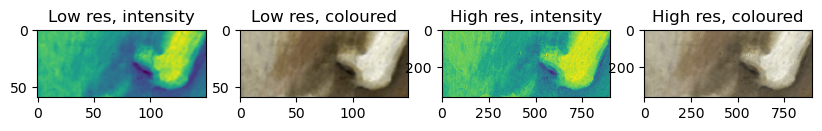

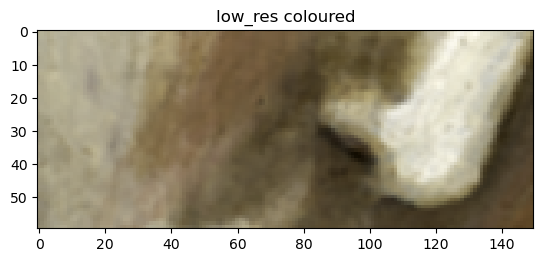

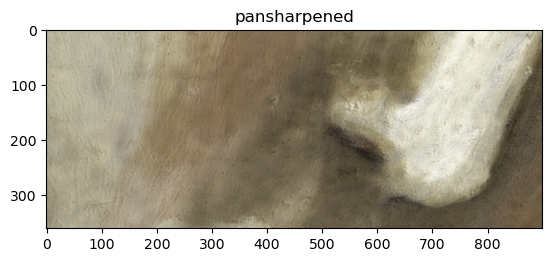

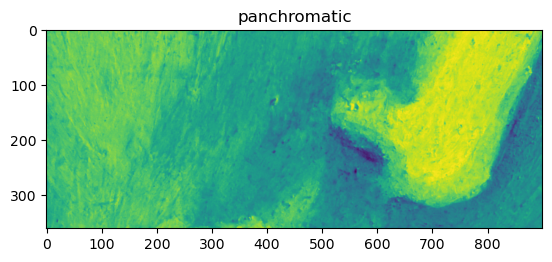

In [6]:
mat_in = io.loadmat(r"Datasets/aviva_nose_aligned_r6_filtered.mat")
#mat_in = io.loadmat(config["input"])

wl_cal = np.squeeze(mat_in["Wavelengths"].astype("float32"))
#wl_cal = wl_cal[::100]

ms = mat_in["I_MS_LR"].astype("float32")
ms = np_normalize(ms)

hr_img = mat_in["I_PAN"].astype("float32")
hr_img = np_normalize(hr_img)

# tmp = io.loadmat(r"Outputs\R-PNN\20250612_112930\aviva_eye_aligned_copy_R-PNN.mat")
mat_out = io.loadmat(r"Outputs/R-PNN/20250716_163140/aviva_nose_aligned_r6_filtered_R-PNN.mat")
pansharpened = mat_out["I_MS"].astype("float32")
# pansharpened = pansharpened.squeeze().transpose(1,2,0)

lr_img = np.sum(ms,2) # grayscale lr image, float32

# color the ms image
rgb_lr = hsi_to_rgb(ms, wl_cal)
rgb_hr = hsi_to_rgb(pansharpened, wl_cal)

fig, ax = plt.subplots(1,4, figsize = (10,5))
ax[0].imshow(lr_img)
ax[0].set_title("Low res, intensity");
ax[1].imshow(rgb_lr)
ax[1].set_title("Low res, coloured");
ax[2].imshow(hr_img)
ax[2].set_title("High res, intensity");
ax[3].imshow(rgb_hr)
ax[3].set_title("High res, coloured");


fig0, ax0 = plt.subplots()
ax0.imshow(rgb_lr)
ax0.set_title("low_res coloured");

fig1, ax1 = plt.subplots()
ax1.imshow(rgb_hr)
ax1.set_title("pansharpened");


fig2, ax2 = plt.subplots()
ax2.imshow(hr_img)
ax2.set_title("panchromatic");

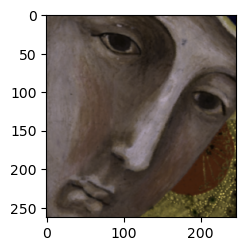

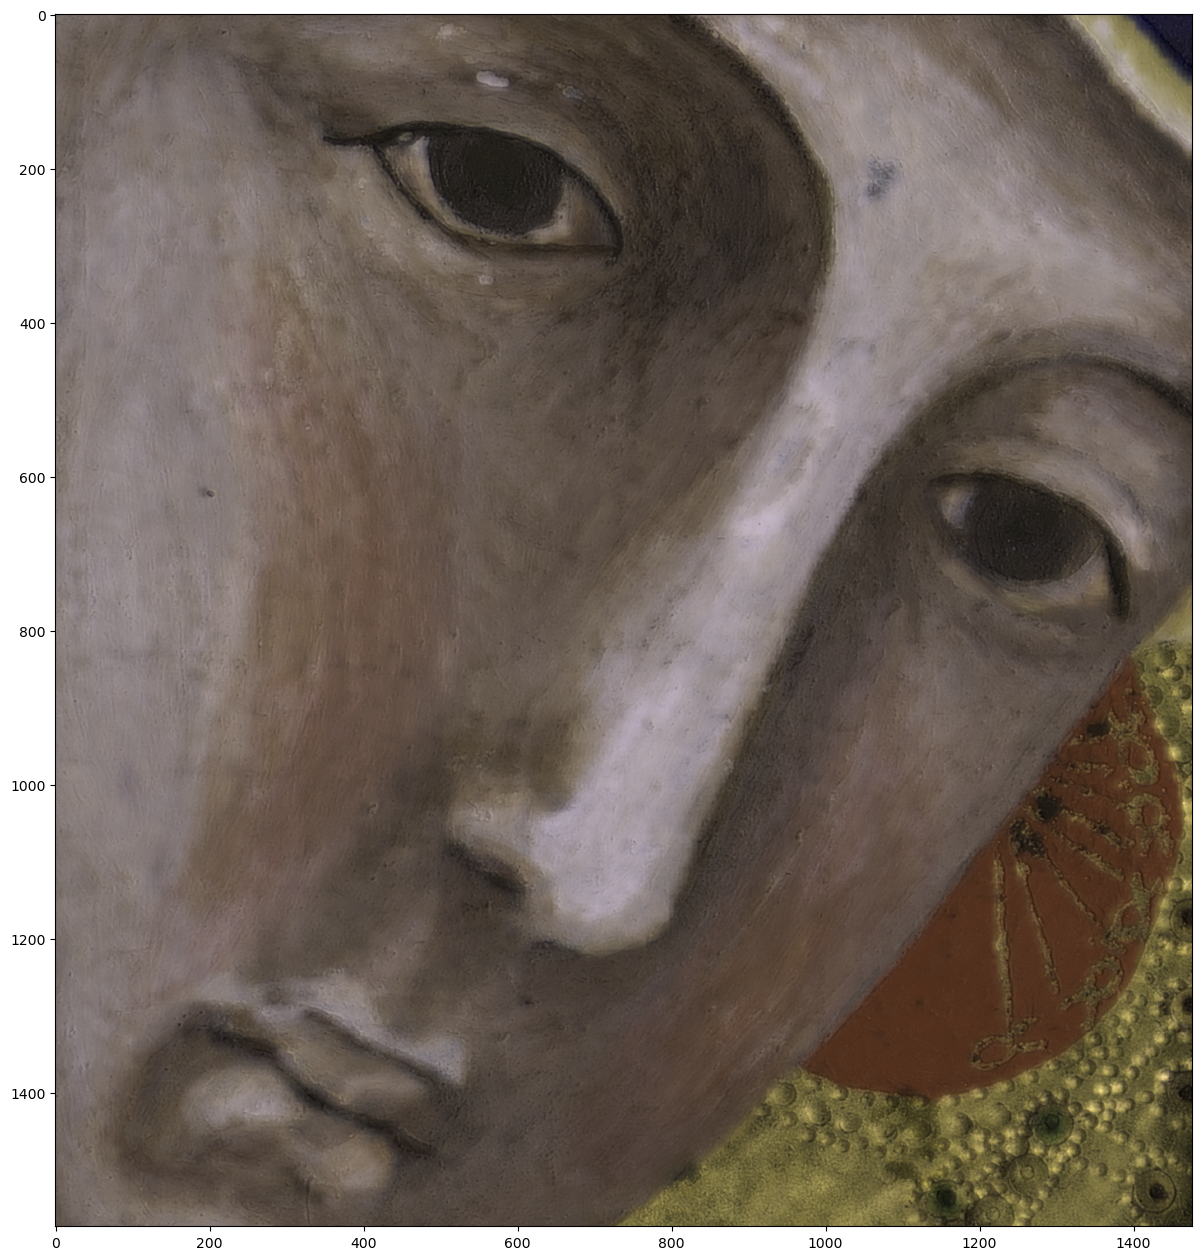

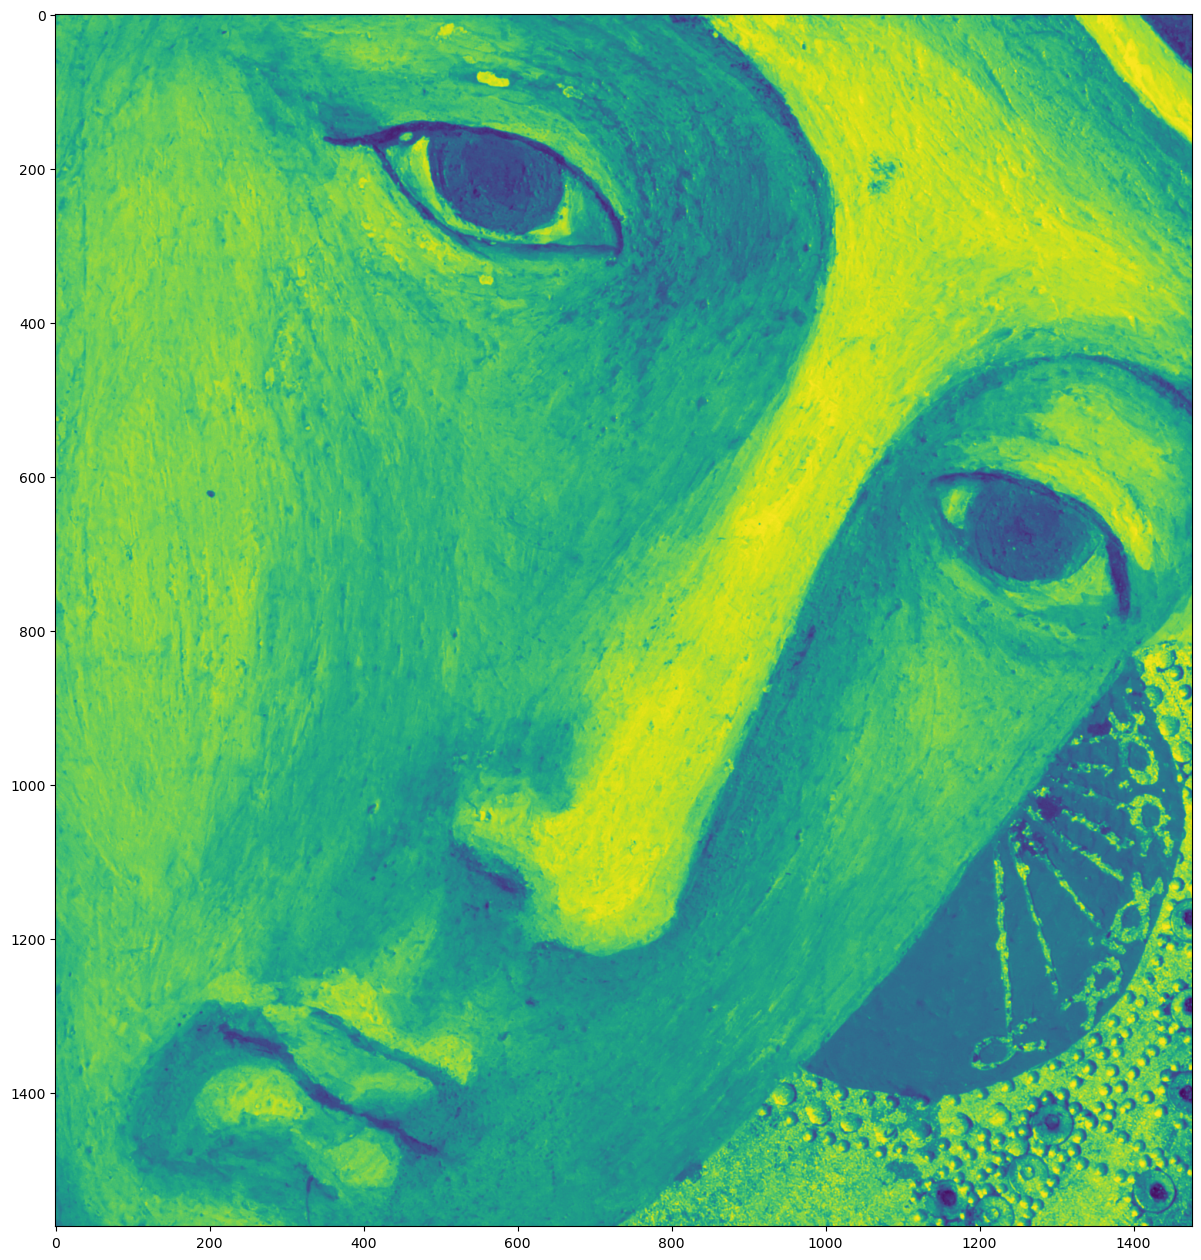

In [9]:
def show_image(img, dpi=100):
    height, width = img.shape[:2]
    figsize = (width / dpi, height / dpi)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.imshow(img)
    # ax.axis('off')
    plt.show()

# Llamadas
show_image(rgb_lr)
show_image(rgb_hr)
show_image(hr_img)

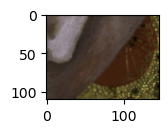

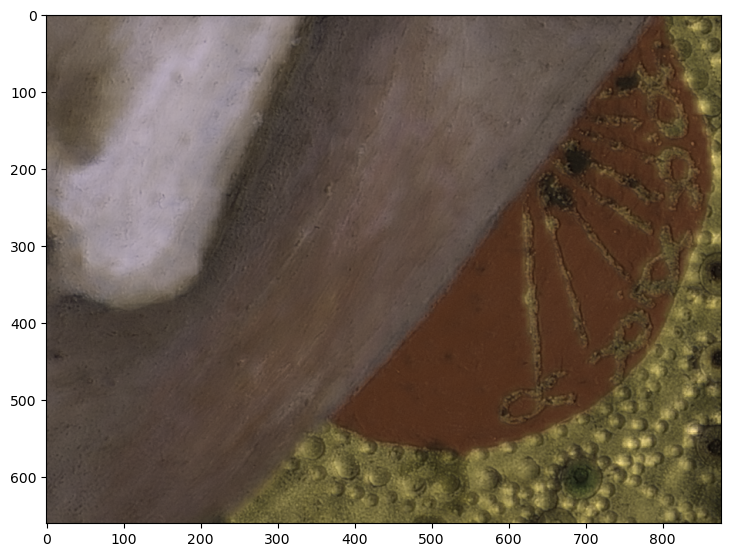

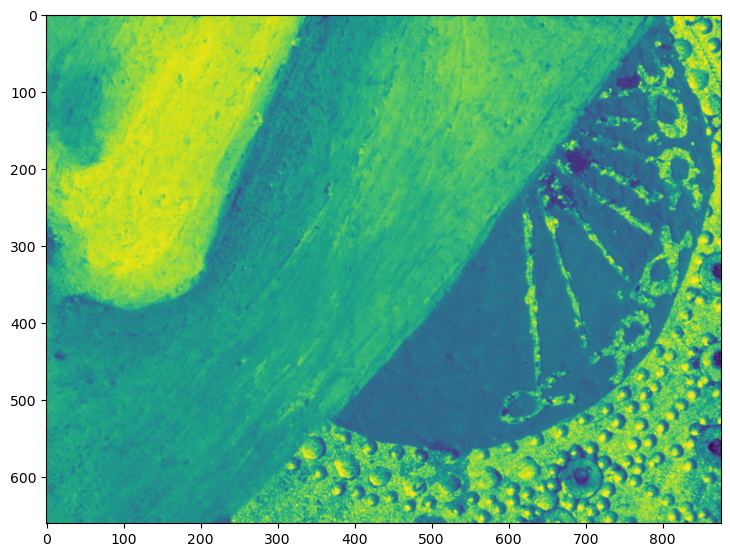

In [14]:
brightness_offset = 0.0
contrast = 1
row_t_0 = 140
row_t_f = 250

col_t_0 = 100
col_t_f = 250


show_image(np.clip(contrast*rgb_lr[row_t_0:row_t_f,col_t_0:col_t_f]+brightness_offset, a_min=0, a_max = 1.0))
show_image(np.clip(contrast*rgb_hr[config["ratio"]*row_t_0:config["ratio"]*row_t_f , config["ratio"]*col_t_0:config["ratio"]*col_t_f]+brightness_offset, a_min=0, a_max = 1.0))
show_image(hr_img[config["ratio"]*row_t_0:config["ratio"]*row_t_f,config["ratio"]*col_t_0:config["ratio"]*col_t_f])

In [ ]:
# Analyse the results with polygon selector

In [ ]:
# agument parser


'''
if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        prog="R-PNN Training code",
        formatter_class=argparse.RawDescriptionHelpFormatter,
        description="R-PNN is an unsupervised deep learning-based pansharpening "
        "method.",
        epilog="""\
Reference: 
Band-wise Hyperspectral Image Pansharpening using CNN Model Propagation
G. Guarino, M. Ciotola, G. Vivone, G. Scarpa 

Authors: 
- Image Processing Research Group of University of Naples Federico II ('GRIP-UNINA')
- National Research Council, Institute of Methodologies for Environmental Analysis (CNR-IMAA)
- University of Naples Parthenope

For further information, please contact the first author by email: giuseppe.guarino2[at]unina.it """,
    )
    optional = parser._action_groups.pop()
    required = parser.add_argument_group("required named arguments")

    required.add_argument(
        "-i",
        "--input",
        type=str,
        required=True,
        help="The path of the .mat file"
        "For more details, please refer to the GitHub documentation.",
    )

    optional.add_argument(
        "-o",
        "--out_dir",
        type=str,
        default="Outputs",
        help="The directory in which save the outcome.",
    )

    optional.add_argument(
        "-n_gpu",
        "--gpu_number",
        type=int,
        default=0,
        help="Number of the GPU on which perform the " "algorithm.",
    )
    optional.add_argument(
        "--use_cpu",
        action="store_true",
        help="Force the system to use CPU instead of GPU. It could solve OOM problems, but the "
        "algorithm will be slower.",
    )

    optional.add_argument(
        "-lr",
        "--learning_rate",
        type=float,
        default=-1.0,
        help="Learning rate with which perform the training.",
    )

    optional.add_argument(
        "--pretrained",
        action="store_true",
        help="Load pretrained model weights. If not set, training will start from scratch.",
    )

    parser._action_groups.append(optional)
    arguments = parser.parse_args()
'''